# Set up

In [1]:
!pip install ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56

In [2]:
import sys
print(sys.version)
import os
import random
import ultralytics
ultralytics.checks()
from IPython.core.display import mimetypes, display, Image


from ultralytics import YOLO

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 42.3/235.7 GB disk)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/blackbird/mite_detection

/content/drive/MyDrive/blackbird/mite_detection


In [5]:
set_seed = 42
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/blackbird/mite_detection


In [6]:
%cd /content/drive/MyDrive/blackbird/mite_detection

/content/drive/MyDrive/blackbird/mite_detection


In [6]:
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8
!export CUDA_LAUNCH_BLOCKING=1

In [7]:
!nvidia-smi

Mon Jul 21 22:30:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Baseline no other hosts, even split

## Made custom split with split_dataset.py

In [ ]:
import os
import glob
import shutil
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

# Original directories for images and labels
orig_images_dir = '/Users/michelewiseman/Downloads/TSSM Detection v2.v173i.yolov11/train/images'
orig_labels_dir = '/Users/michelewiseman/Downloads/TSSM Detection v2.v173i.yolov11/train/labels'

# Destination directories for splits
dest_dirs = {
    "train": {"images": "/Users/michelewiseman/Downloads/TSSM Detection v2.v173i.yolov11/train_split/images", "labels": "/Users/michelewiseman/Downloads/TSSM Detection v2.v173i.yolov11/train_split/labels"},
    "valid": {"images": "/Users/michelewiseman/Downloads/TSSM Detection v2.v173i.yolov11/valid/images", "labels": "/Users/michelewiseman/Downloads/TSSM Detection v2.v173i.yolov11/valid/labels"},
    "test": {"images": "/Users/michelewiseman/Downloads/TSSM Detection v2.v173i.yolov11/test/images", "labels": "/Users/michelewiseman/Downloads/TSSM Detection v2.v173i.yolov11/test/labels"}
}

# Create destination directories if they don't exist
for split in dest_dirs:
    os.makedirs(dest_dirs[split]["images"], exist_ok=True)
    os.makedirs(dest_dirs[split]["labels"], exist_ok=True)

# Get all label files from the original labels directory
label_files = sorted(glob.glob(os.path.join(orig_labels_dir, '*.txt')))
if not label_files:
    raise ValueError("No label files found in " + orig_labels_dir)

# Lists to store image file paths and the classes present in each image
image_files = []
image_classes = []
all_classes_set = set()

# Process each label file to find the corresponding image and extract class info
for label_file in label_files:
    base_name = os.path.splitext(os.path.basename(label_file))[0]
    possible_image = None
    for ext in ['.jpg', '.jpeg', '.png']:
        candidate = os.path.join(orig_images_dir, base_name + ext)
        if os.path.exists(candidate):
            possible_image = candidate
            break
    if possible_image is None:
        print(f"Warning: No image found for label file {label_file}")
        continue
    image_files.append(possible_image)

    # Read the YOLO-format label file: class x_center y_center width height
    classes_in_image = set()
    with open(label_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                try:
                    cls = int(parts[0])
                    classes_in_image.add(cls)
                    all_classes_set.add(cls)
                except ValueError:
                    print(f"Skipping invalid line in {label_file}: {line}")
    image_classes.append(classes_in_image)

# Determine sorted list of unique classes
unique_classes = sorted(list(all_classes_set))
num_classes = len(unique_classes)
print("Unique classes found:", unique_classes)

# Create a multi-hot encoding for each image (rows: images, columns: classes)
Y = np.zeros((len(image_files), num_classes), dtype=int)
for i, classes in enumerate(image_classes):
    for cls in classes:
        idx = unique_classes.index(cls)
        Y[i, idx] = 1

# Prepare X as a numpy array of file paths (reshaped as a column vector)
X = np.array(image_files).reshape(-1, 1)

# --- Split the dataset using iterative stratification ---
# First, split into 80% train and 20% remainder
train_frac = 0.8
X_train, Y_train, X_rem, Y_rem = iterative_train_test_split(X, Y, test_size=1 - train_frac)

# Then split the remaining 20% equally into validation and test sets (10% each overall)
X_valid, Y_valid, X_test, Y_test = iterative_train_test_split(X_rem, Y_rem, test_size=0.5)

# Flatten the arrays of file paths
X_train = X_train.flatten()
X_valid = X_valid.flatten()
X_test = X_test.flatten()

print(f"\nSplit counts:")
print(f"Train images: {len(X_train)}")
print(f"Validation images: {len(X_valid)}")
print(f"Test images: {len(X_test)}")


# --- Compute and print class distributions for each split ---
def compute_class_distribution(Y_array):
    return np.sum(Y_array, axis=0)


dist_train = compute_class_distribution(Y_train)
dist_valid = compute_class_distribution(Y_valid)
dist_test = compute_class_distribution(Y_test)

print("\nClass Distribution (per split):")
print("Class\tTrain\tValidation\tTest")
for i, cls in enumerate(unique_classes):
    print(f"{cls}\t{dist_train[i]}\t{dist_valid[i]}\t\t{dist_test[i]}")


# --- Function to move image and label files for a given split ---
def move_files(file_list, split_name):
    images_dest = dest_dirs[split_name]["images"]
    labels_dest = dest_dirs[split_name]["labels"]
    for image_path in file_list:
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        # Define source and destination for the label file (assumed extension: .txt)
        src_label = os.path.join(orig_labels_dir, base_name + ".txt")
        dest_label = os.path.join(labels_dest, base_name + ".txt")
        dest_image = os.path.join(images_dest, os.path.basename(image_path))

        print(f"Moving image: {image_path} -> {dest_image}")
        shutil.move(image_path, dest_image)

        if os.path.exists(src_label):
            print(f"Moving label: {src_label} -> {dest_label}")
            shutil.move(src_label, dest_label)
        else:
            print(f"Warning: Label file {src_label} not found!")


# --- Move files for each split ---
move_files(X_train, "train")
move_files(X_valid, "valid")
move_files(X_test, "test")


## Train

In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/baseline_no_aug_no_other_hosts/data.yaml epochs=100 imgsz=1024

WARNING ⚠️ conflicting 'task=segment' passed with 'task=detect' model. Ignoring 'task=segment' and updating to 'task=detect' to match model.
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/baseline_no_aug_no_other_hosts/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train71, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vis

## Results

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.08s/it]
                   all         82       1807      0.773      0.797      0.777      0.497
          Adult_female         31         41       0.87      0.976      0.976      0.634
            Adult_male         16         58      0.688        0.5      0.581       0.34
             Dead_mite         24        145      0.466      0.776       0.49      0.297
              Immature         53        568      0.864      0.804      0.864      0.508
            Viable_egg         71        995      0.978       0.93      0.974      0.706
Speed: 0.3ms preprocess, 7.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train71
💡 Learn more at https://docs.ultralytics.com/modes/train
"""

## Test set

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train71/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/baseline_no_aug_no_other_hosts/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

WARNING ⚠️ conflicting 'task=segment' passed with 'task=detect' model. Ignoring 'task=segment' and updating to 'task=detect' to match model.
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/baseline_no_aug_no_other_hosts/valid/labels... 80 images, 0 backgrounds, 0 corrupt: 100% 80/80 [00:33<00:00,  2.42it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/baseline_no_aug_no_other_hosts/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:17<00:00,  3.58s/it]
                   all         80       1731      0.791       0.76      0.784      0.499
          Adult_female         29         48      0.755      0.771      0.811      0.523
            Adult_male         17         38      0.628      0.711      0

## Performance on other host test sets

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train71/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train71/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train71/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100% 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:09<00:00,  2.31s/it]
                   all         52        514      0.567      0.532      0.511      0.339
          Adult_female         16         20        0.6        0.3      0.448      0.252
            Adult_male          9          9          0          0          0          0
             Dead_mite          3          3      0.324          1      0.456      0.266
              Immature         26         53       0.93      0.499      0.713      0.453
            Viable_egg         52        429      0.982      0.862      0.935  

## Add 100 hop synthetic images

These are the same images and data as the segmentation set (just converted to bounding boxes)

In [ ]:
!yolo task=detect mode=train model=yolo11x.pt data=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/data.yaml epochs=100 imgsz=1024 batch=16

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train75, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, s

In [ ]:
!yolo task=detect mode=train model=yolo11x.pt data=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/data.yaml epochs=100 imgsz=1024 batch=16 patience=25

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train76, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sa

In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/data.yaml epochs=100 imgsz=1024 batch=16

## Results

Shockingly marginal improvements.

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:01<00:00,  2.37it/s]
                   all         82       1807      0.776      0.785      0.783      0.508
          Adult_female         31         41      0.853      0.976      0.973      0.647
            Adult_male         16         58      0.702      0.552      0.641      0.406
             Dead_mite         24        145      0.451      0.745      0.476      0.285
              Immature         53        568      0.896      0.741       0.85      0.501
            Viable_egg         71        995      0.979      0.914      0.974      0.702
Speed: 0.3ms preprocess, 7.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train72

"""

## Test set

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train71/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/valid/labels... 80 images, 0 backgrounds, 0 corrupt: 100% 80/80 [00:29<00:00,  2.74it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:15<00:00,  3.13s/it]
                   all         80       1731      0.791       0.76      0.784      0.499
          Adult_female         29         48      0.755      0.771      0.811      0.523
            Adult_male         17         38      0.628      0.711      0.676      0.334
             Dead_mite         31         93      0.675      0.602      0.611      0.389
              Immature         53       

## Other host test sets

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train72/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train72/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train72/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/labels... 52 images, 0 backgrounds, 0 corrupt: 100% 52/52 [00:22<00:00,  2.36it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:20<00:00,  5.20s/it]
                   all         52        514      0.598      0.558       0.59      0.395
          Adult_female         16         20       0.61      0.392       0.45      0.246
            Adult_male          9          9          0          0          0          0
             Dead_mite          3          3      0.599      0.997      0.863      0.596
              Immature         26         53      0.

# Baseline with strawberry images
Same exact annotations, just with strawberry backgrounds.

In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_strawberry_syn_images_bb/data.yaml epochs=100 imgsz=1024

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_strawberry_syn_images_bb/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train73, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

## Results

In [ ]:
"""
Looks like it didnt save, but the best mAP50 was around 0.78 (recall also about 0.78)

Viable egg and female performance = good. Male, dead, and immature poor.
"""

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train73/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/test/images show_labels=true conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs

image 1/80 /content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/test/images/001-cascade_2_11_jpg.rf.7f5c1b192bd8caf482ab45d03e7a87f4.jpg: 1024x1024 3 Immatures, 19.6ms
image 2/80 /content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/test/images/001-cascade_mites_rnd2_png.rf.f380d67e1d5c5579c25a14342d445e24.jpg: 1024x1024 1 Adult_male, 11 Immatures, 8 Viable_eggs, 20.6ms
image 3/80 /content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/test/images/001-filter_paper_test_png.rf.c2cc3c86d267779514204452adff5d3e.jpg: 1024x1024 1 Adult_female, 41 Viable_eggs, 19.5ms
image 4/80 /content/drive/MyDrive/blackbird/mite_detection/baseline_with_hop_syn_images/test/images/001-willamette_field_mites_png.rf.8ab55e457fc641f10a6f325ae69a2fba.jpg: 1024x1024 1

## Other host test sets

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train73/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train73/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train73/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
100% 755k/755k [00:00<00:00, 14.6MB/s]
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100% 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:16<00:00,  4.00s/it]
                   all         52        514      0.474      0.525       0.54      0.337
          Adult_female         16         20      0.379        0.4      0.348      0.118
            Adult_male          9          9          0          0          0          0
             Dead_mite          3          3      0.333          1      0.913      0.518
              Immature         26         53      0.686      0.413      0.509      0.298
            Viable_egg         52       

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train73/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/images show_labels=true conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs

image 1/52 /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/images/001-strawberry_mite_1_png.rf.dfd134194e244d8d0d16e0b9ba4b3d24.jpg: 704x1024 2 Dead_mites, 37 Viable_eggs, 65.6ms
image 2/52 /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/images/001-strawberry_mite_png.rf.7a35c44e6873ff368d044ba7e65abe03.jpg: 704x1024 40 Viable_eggs, 19.6ms
image 3/52 /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/images/002-strawberry_mite_1_png.rf.a81a70861d429b9d6b4cc5fe62f46a8b.jpg: 704x1024 6 Viable_eggs, 19.0ms
image 4/52 /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/images/002-strawberry_mite_png.rf.3f47837df70086cd2e4aaab36bd6ae1c.jpg: 704x1024 6 Viable_eggs, 18.8ms
image 5/52 /content/drive/MyDrive/b

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train73/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/valid/images show_labels=true conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs

image 1/29 /content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/valid/images/001-raspberry_mites_png.rf.aa06b5df87237f70aafa4398b6c67710.jpg: 704x1024 1 Adult_female, 6 Immatures, 21 Viable_eggs, 65.3ms
image 2/29 /content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/valid/images/002-raspberry_mites_png.rf.4d84f69199681dfae009a5f9b32e2bf2.jpg: 704x1024 1 Adult_female, 1 Dead_mite, 3 Immatures, 7 Viable_eggs, 19.5ms
image 3/29 /content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/valid/images/003-raspberry_mites_png.rf.f53a24910d9f86f85b1a71ceb04a363f.jpg: 704x1024 1 Adult_female, 2 Dead_mites, 3 Immatures, 15 Viable_eggs, 19.3ms
image 4/29 /content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/valid/images/004-raspberry_mites_png.rf.5b2e6a7cfeb8

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train73/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/valid/images show_labels=true conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs

image 1/23 /content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/valid/images/001-columbine_mite_png.rf.bdb44810510aa9dd3251b9cb32c06d9d.jpg: 704x1024 1 Adult_female, 3 Immatures, 65.4ms
image 2/23 /content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/valid/images/003-columbine_mite_png.rf.1188c13d3973b6058ab61c3ff411d8cf.jpg: 704x1024 1 Adult_female, 19.4ms
image 3/23 /content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/valid/images/004-columbine_mite_png.rf.9ac178f40cbf45789f4f7b5eeb54bc7f.jpg: 704x1024 3 Dead_mites, 15 Immatures, 13 Viable_eggs, 18.9ms
image 4/23 /content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/valid/images/005-columbine_mite_png.rf.418809e11710c4c5694d051d2f8bbd32.jpg: 704x1024 2 Adult_males, 4 Dead_mites, 11 Immatures

#v179 Baseline (included the grid images and just used the roboflow split to make reproducibility easier)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(179)
#dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml epochs=100 imgsz=1024

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train78, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

In [ ]:
"""
Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:01<00:00,  2.46it/s]
                   all         85       1080       0.81      0.802      0.851      0.546
          Adult_female         34         47      0.794      0.915      0.916      0.599
            Adult_male         16         21      0.725      0.755      0.777      0.502
             Dead_mite         26         69      0.726      0.615      0.737      0.452
              Immature         48        201      0.861      0.826      0.889      0.502
            Viable_egg         68        742      0.945      0.898      0.938      0.676
Speed: 0.3ms preprocess, 7.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train78
💡 Learn more at https://docs.ultralytics.com/modes/train78
"""

## Test set

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train78/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/valid/labels... 83 images, 0 backgrounds, 0 corrupt: 100% 83/83 [00:00<00:00, 266.05it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:05<00:00,  1.17it/s]
                   all         83       1748      0.831      0.664      0.756      0.506
          Adult_female         27         45      0.805      0.733      0.812      0.548
            Adult_male         20         43      0.826      0.442      0.665       0.42
             Dead_mite         37        177      0.676      0.554      0.565      0.379
              Immature         64        644      0.8

## Try on other host test set

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train78/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train78/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train78/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100% 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:29<00:00,  7.42s/it]
                   all         52        514       0.85      0.464      0.572      0.404
          Adult_female         16         20      0.675       0.45      0.507      0.285
            Adult_male          9          9          1          0          0          0
             Dead_mite          3          3      0.711      0.667      0.777      0.572
              Immature         26         53      0.887      0.443      0.679      0.453
            Viable_egg         52        429      0.975       0.76      0.898  

## swap test and val

what if i swapped the test and val sets and trained again?

In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml epochs=100 imgsz=1024

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train79, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

slightly worse, but still pretty comparable.

In [ ]:
"""
Validating runs/detect/train79/weights/best.pt...
Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.06s/it]
                   all         83       1748      0.767      0.821      0.827      0.514
          Adult_female         27         45      0.799      0.956      0.924      0.577
            Adult_male         20         43      0.759       0.66      0.725      0.411
             Dead_mite         37        177      0.497       0.74      0.645      0.401
              Immature         64        644      0.847      0.835      0.887      0.497
            Viable_egg         78        839      0.932      0.913      0.953      0.683
Speed: 0.3ms preprocess, 7.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train79
💡 Learn more at https://docs.ultralytics.com/modes/train
"""

## Test set

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train79/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

2 of 3 test sets have better performance though.

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train79/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train79/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train79/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100% 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:08<00:00,  2.22s/it]
                   all         52        514      0.665      0.489      0.598      0.423
          Adult_female         16         20      0.714        0.5      0.596      0.319
            Adult_male          9          9          0          0          0          0
             Dead_mite          3          3      0.667      0.667      0.777      0.666
              Immature         26         53      0.958      0.434      0.696      0.426
            Viable_egg         52        429      0.984      0.846      0.919  

## Add the 100 synthetic hop images in
(I did this manually in google drive)

In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml epochs=100 imgsz=1024

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train80, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

## Results

In [ ]:
"""
Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.01s/it]
                   all         83       1748      0.795      0.781      0.822      0.519
          Adult_female         27         45      0.804      0.819      0.881       0.57
            Adult_male         20         43      0.793      0.712      0.757      0.445
             Dead_mite         37        177      0.591      0.644      0.636      0.395
              Immature         64        644      0.842      0.826      0.878      0.496
            Viable_egg         78        839      0.944      0.907      0.959      0.689
Speed: 0.3ms preprocess, 7.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train80
💡 Learn more at https://docs.ultralytics.com/modes/train80
"""

Performance is worse. That's pretty surprising... but maybe only really beneficial with segmentation?

## Test sets

swapped test and valid

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train80/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/valid/labels... 85 images, 1 backgrounds, 0 corrupt: 100% 85/85 [00:26<00:00,  3.23it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:13<00:00,  2.27s/it]
                   all         85       1080      0.812      0.795      0.816      0.547
          Adult_female         34         47      0.825      0.904      0.907        0.6
            Adult_male         16         21      0.653      0.714      0.671      0.412
             Dead_mite         26         69      0.756      0.638       0.72       0.48
              Immature         48        201       0.8

### Other hosts

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train80/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train80/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train80/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
100% 755k/755k [00:00<00:00, 108MB/s]
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100% 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:28<00:00,  7.04s/it]
                   all         52        514       0.58      0.569      0.602      0.352
          Adult_female         16         20      0.445        0.3      0.349      0.126
            Adult_male          9          9      0.391      0.222      0.288     0.0672
             Dead_mite          3          3      0.313          1      0.806      0.484
              Immature         26         53      0.784      0.453      0.622      0.323
            Viable_egg         52        

## Removed hop images and added tomato images instead

In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml epochs=100 imgsz=1024

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train81, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.06s/it]
                   all         83       1748      0.809      0.756      0.825      0.512
          Adult_female         27         45      0.825        0.8      0.891      0.548
            Adult_male         20         43       0.77      0.628      0.739      0.416
             Dead_mite         37        177      0.645      0.638      0.663      0.416
              Immature         64        644      0.862      0.812      0.878      0.498
            Viable_egg         78        839      0.943        0.9      0.953      0.684
Speed: 0.3ms preprocess, 6.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train81
💡 Learn more at https://docs.ultralytics.com/modes/train81
"""

## Test set

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-179/valid/labels.cache... 85 images, 1 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:04<00:00,  1.31it/s]
                   all         85       1080      0.822      0.753       0.78      0.521
          Adult_female         34         47      0.783      0.846      0.802      0.535
            Adult_male         16         21      0.645      0.667      0.606      0.337
             Dead_mite         26         69      0.807      0.565      0.692      0.473
              Immature         48        201       0.91      0.803      0.864      0.525
            Viable_egg         68        742      0.963      0.886      0.935   

Performance is about the same.

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set_bb/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100% 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:13<00:00,  3.34s/it]
                   all         52        514        0.3    0.00424      0.153     0.0807
          Adult_female         16         20          0          0          0          0
            Adult_male          9          9          0          0          0          0
             Dead_mite          3          3          0          0          0          0
              Immature         26         53        0.5     0.0189      0.262     0.0524
            Viable_egg         52        429          1    0.00233      0.501  

Enormous decrease in strawberry test set performance, raspberry and columbine remain similar.

# COE baseline (v179 re-run)

Worse performance, maybe because of 32 batch vs 16 batch?

In [ ]:
"""

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]
                   all         85       1080      0.787      0.821      0.828       0.53
          Adult_female         34         47      0.755      0.915      0.881      0.603
            Adult_male         16         21      0.636      0.762      0.685      0.388
             Dead_mite         26         69      0.707      0.696      0.703      0.441
              Immature         48        201      0.879      0.831       0.91      0.519
            Viable_egg         68        742      0.955      0.902      0.958      0.697
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train215


## Test set

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]
                   all         83       1748      0.814      0.717      0.773      0.514
          Adult_female         27         45      0.756      0.756      0.793      0.518
            Adult_male         20         43      0.828      0.558      0.709      0.423
             Dead_mite         37        177      0.653      0.627      0.602      0.415
              Immature         64        644      0.879       0.78       0.84      0.498
            Viable_egg         78        839      0.954      0.864      0.921      0.716
Speed: 21.0ms preprocess, 23.6ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs/detect/val30


## Other hosts

### Strawberry

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train215/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:27<00:00,  6.79s/it]
                   all         52        514      0.618      0.434      0.549      0.363
          Adult_female         16         20      0.621        0.5      0.547       0.36
            Adult_male          9          9          0          0          0          0
             Dead_mite          3          3       0.58          1      0.913      0.598
              Immature         26         53      0.943      0.313      0.557      0.314
            Viable_egg         52        429      0.944      0.356       0.73      0.542
Speed: 21.2ms preprocess, 54.5ms inference, 0.0ms loss, 50.0ms postprocess per image
Results saved to runs/detect/val28



### Raspberry

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train215/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.85s/it]
                   all         29        202      0.549      0.437      0.497      0.307
          Adult_female         14         15        0.8      0.533      0.661      0.329
            Adult_male          1          1          0          0          0          0
             Dead_mite         13         34      0.541      0.588      0.578       0.38
              Immature         12         38      0.615      0.632      0.656      0.377
            Viable_egg         23        114       0.79       0.43      0.592      0.449
Speed: 10.5ms preprocess, 63.8ms inference, 0.0ms loss, 18.6ms postprocess per image
Results saved to runs/detect/val27

"""

### Columbine

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train215/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.47s/it]
                   all         23        285      0.646       0.57      0.592      0.283
          Adult_female          4         18       0.75      0.667      0.688      0.199
            Adult_male          8         11      0.714      0.455      0.576      0.156
             Dead_mite          5         14      0.154      0.286      0.157      0.125
              Immature         21         87      0.637      0.667      0.662      0.253
            Viable_egg         18        155      0.976      0.774      0.879       0.68
Speed: 24.1ms preprocess, 81.6ms inference, 0.0ms loss, 15.8ms postprocess per image
Results saved to runs/detect/val29

"""


# COE Baseline + Hop Run

Huh, on COE the baseline + hop is better than the baseline.

In [ ]:
"""
yolo task=detect mode=train model=yolo11l.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-179_hop/data.yaml epochs=100 imgsz=1024 plots=True batch=32 workers=2 patience=25

yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train216/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-179_hop/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

YOLO11l summary (fused): 464 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]
                   all         85       1080      0.836      0.809      0.853       0.55
          Adult_female         34         47      0.823      0.892      0.917      0.633
            Adult_male         16         21      0.702       0.81       0.74      0.429
             Dead_mite         26         69      0.801      0.667      0.764      0.492
              Immature         48        201      0.901      0.811      0.905      0.521
            Viable_egg         68        742      0.952      0.865      0.942      0.674
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train216


## Test set

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train216/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-179_hop/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6
                   all         83       1748      0.791      0.719      0.761      0.504
          Adult_female         27         45      0.786      0.733      0.806      0.523
            Adult_male         20         43      0.658      0.581      0.644      0.379
             Dead_mite         37        177      0.642      0.638      0.592      0.402
              Immature         64        644      0.915      0.773      0.842      0.514
            Viable_egg         78        839      0.952      0.867      0.924        0.7
Speed: 4.2ms preprocess, 17.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/val22





## Other host test sets

#### Strawberry

In [ ]:
"""
                Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4
                   all         52        514      0.712      0.474      0.602      0.406
          Adult_female         16         20       0.62       0.35      0.464      0.254
            Adult_male          9          9          0          0          0          0
             Dead_mite          3          3          1      0.963      0.995      0.673
              Immature         26         53      0.948      0.347      0.663      0.418
            Viable_egg         52        429       0.99      0.713      0.887      0.685
Speed: 5.2ms preprocess, 40.9ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to runs/detect/val23

"""

#### Raspberry

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train216/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2
                   all         29        202       0.57      0.505      0.555      0.359
          Adult_female         14         15      0.778      0.467      0.674      0.395
            Adult_male          1          1          0          0          0          0
             Dead_mite         13         34      0.594      0.559      0.513      0.344
              Immature         12         38      0.675      0.711      0.738      0.408
            Viable_egg         23        114      0.804      0.789      0.851      0.647
Speed: 0.2ms preprocess, 66.3ms inference, 0.0ms loss, 24.7ms postprocess per image
Results saved to runs/detect/val24
"""

#### Columbine

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train216/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2
                   all         23        285      0.699      0.563      0.617      0.307
          Adult_female          4         18      0.769      0.556      0.617      0.239
            Adult_male          8         11      0.857      0.545      0.702      0.167
             Dead_mite          5         14      0.211      0.286      0.227      0.169
              Immature         21         87      0.693      0.598      0.629      0.241
            Viable_egg         18        155      0.963      0.832       0.91       0.72
Speed: 8.9ms preprocess, 52.7ms inference, 0.0ms loss, 19.6ms postprocess per image
Results saved to runs/detect/val26



# COE Strawberry Run

In [ ]:
"""
export PATH=$PATH:/nfs/stak/users/wisemami/.local/bin

yolo task=detect mode=train model=yolo11l.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-179/data.yaml epochs=100 imgsz=1024 plots=True batch=32 patience=25

"""

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]
                   all         85       1080      0.786      0.804      0.831      0.522
          Adult_female         34         47      0.739      0.915      0.912      0.612
            Adult_male         16         21      0.689       0.81      0.731       0.42
             Dead_mite         26         69      0.664      0.631       0.69      0.429
              Immature         48        201      0.883      0.788      0.883      0.488
            Viable_egg         68        742      0.958      0.876       0.94      0.659
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train206
"""

## Test set

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]
                   all         83       1748      0.815      0.671      0.749      0.491
          Adult_female         27         45      0.773      0.756      0.819      0.508
            Adult_male         20         43      0.793      0.535      0.654      0.409
             Dead_mite         37        177      0.642      0.497      0.538      0.355
              Immature         64        644      0.906       0.72      0.819      0.492
            Viable_egg         78        839      0.962      0.845      0.916      0.688
Speed: 4.4ms preprocess, 17.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val12

"""

## COE other test sets

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train206/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train206/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train206/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train229/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/strawberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train229/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/columbine_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train229/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024
yolo task=segment mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/segment/train19/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/segmentation_test_sets/strawberry/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42



Strawberry

In [ ]:
"""

yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train216/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/raspberry_test_set_bb/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.59s/it]
                   all         52        514      0.658      0.559      0.685      0.359
          Adult_female         16         20      0.421        0.4      0.423       0.19
            Adult_male          9          9          1      0.111      0.556      0.111
             Dead_mite          3          3      0.333          1      0.995      0.566
              Immature         26         53      0.575      0.434      0.532      0.257
            Viable_egg         52        429       0.96      0.848      0.917       0.67
Speed: 19.8ms preprocess, 29.8ms inference, 0.0ms loss, 11.6ms postprocess per image
Results saved to runs/detect/val5
"""


Raspberry

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.09s/it]
                   all         29        202      0.525      0.539      0.563      0.357
          Adult_female         14         15      0.507        0.6      0.659      0.394
            Adult_male          1          1          0          0          0          0
             Dead_mite         13         34      0.564      0.676      0.643      0.405
              Immature         12         38      0.639      0.553      0.613      0.323
            Viable_egg         23        114      0.916      0.866        0.9      0.664
Speed: 0.2ms preprocess, 59.6ms inference, 0.0ms loss, 28.1ms postprocess per image
Results saved to runs/detect/val6
💡 Learn more at https://docs.ultralytics.com/modes/val



Columbine

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.94s/it]
                   all         23        285      0.489      0.477       0.46       0.26
          Adult_female          4         18      0.404      0.333      0.283     0.0717
            Adult_male          8         11      0.375      0.273      0.354       0.17
             Dead_mite          5         14      0.102      0.357      0.112     0.0879
              Immature         21         87      0.577      0.552      0.621      0.286
            Viable_egg         18        155      0.985      0.871      0.928      0.683
Speed: 32.5ms preprocess, 43.2ms inference, 0.0ms loss, 12.5ms postprocess per image
Results saved to runs/detect/val4


Raspberry and Strawberry performance is better than baseline and hop syn images. columbine is worse.

slightly better than the hop synthetic images alone

# COE combining adding both strawberry and hop synthetic images

Note: these have the same bounding box coordinates, just different backgrounds. I'm expecting this will not help, but I thought I'd try it out anyway.

In [ ]:
"""
yolo task=detect mode=train model=yolo11l.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-179_strawb_hop/data.yaml epochs=100 imgsz=1024 plots=True batch=32 patience=25
"""

In [ ]:
"""
YOLO11l summary (fused): 464 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]
                   all         85       1080      0.807      0.761      0.826      0.533
          Adult_female         34         47      0.746      0.851      0.882      0.618
            Adult_male         16         21      0.636      0.762      0.686      0.428
             Dead_mite         26         69      0.787      0.536      0.722      0.436
              Immature         48        201      0.907      0.786      0.889      0.495
            Viable_egg         68        742      0.961      0.871       0.95      0.687
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train212
"""

yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train226/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-179/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024


Test set

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]
                   all         83       1748      0.826       0.71      0.778      0.525
          Adult_female         27         45      0.761      0.778      0.797      0.537
            Adult_male         20         43      0.848      0.651      0.771      0.499
             Dead_mite         37        177      0.688      0.497      0.572      0.396
              Immature         64        644      0.878      0.761       0.83      0.491
            Viable_egg         78        839      0.953      0.862       0.92      0.702
Speed: 4.1ms preprocess, 18.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val10


Strawberry

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.76s/it]
                   all         52        514      0.756      0.448      0.532       0.33
          Adult_female         16         20      0.419        0.4      0.382      0.165
            Adult_male          9          9          1          0          0          0
             Dead_mite          3          3      0.643          1      0.995      0.567
              Immature         26         53      0.737      0.113      0.382      0.206
            Viable_egg         52        429      0.981      0.729      0.901      0.712
Speed: 5.9ms preprocess, 34.6ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/detect/val7


Raspberry

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.30s/it]
                   all         29        202      0.466      0.477      0.479      0.298
          Adult_female         14         15      0.526      0.667      0.571      0.267
            Adult_male          1          1          0          0          0          0
             Dead_mite         13         34      0.582      0.618      0.607      0.381
              Immature         12         38      0.362      0.373      0.367      0.182
            Viable_egg         23        114      0.859      0.728      0.851      0.659
Speed: 0.2ms preprocess, 51.8ms inference, 0.0ms loss, 15.7ms postprocess per image
Results saved to runs/detect/val8


Columbine

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]
                   all         23        285      0.561      0.556      0.502      0.277
          Adult_female          4         18      0.481        0.5      0.357      0.116
            Adult_male          8         11      0.575      0.617      0.519      0.212
             Dead_mite          5         14      0.115      0.286     0.0681     0.0449
              Immature         21         87      0.677      0.529      0.644      0.305
            Viable_egg         18        155      0.957      0.845      0.923      0.706
Speed: 6.9ms preprocess, 52.2ms inference, 0.0ms loss, 13.5ms postprocess per image
Results saved to runs/detect/val9
"""

# COE adding columbine images to baseline

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]
                   all         85       1080      0.855      0.778      0.871      0.549
          Adult_female         34         47      0.789      0.851      0.908      0.608
            Adult_male         16         21      0.845       0.81      0.855      0.488
             Dead_mite         26         69      0.786      0.551      0.758      0.457
              Immature         48        201      0.901      0.796      0.885      0.508
            Viable_egg         68        742      0.951      0.884      0.948      0.685
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train213

"""

## Test Set

In [ ]:
"""

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]
                   all         83       1748      0.827      0.678      0.768      0.515
          Adult_female         27         45      0.805      0.733      0.816      0.552
            Adult_male         20         43       0.84      0.488      0.693      0.425
             Dead_mite         37        177      0.652      0.508      0.572      0.385
              Immature         64        644      0.888      0.776      0.826      0.496
            Viable_egg         78        839      0.949      0.884      0.934      0.719
Speed: 3.5ms preprocess, 24.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/val18


## Other hosts

Strawberry

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.71s/it]
                   all         52        514      0.786      0.463      0.562       0.36
          Adult_female         16         20      0.499       0.35      0.341      0.146
            Adult_male          9          9          1          0          0          0
             Dead_mite          3          3      0.682          1      0.995      0.644
              Immature         26         53      0.772      0.226      0.561      0.288
            Viable_egg         52        429      0.975      0.738      0.914      0.722
Speed: 17.9ms preprocess, 32.7ms inference, 0.0ms loss, 10.5ms postprocess per image
Results saved to runs/detect/val13


Raspberry

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.72s/it]
                   all         29        202      0.501      0.545      0.523      0.336
          Adult_female         14         15      0.511        0.6      0.639      0.409
            Adult_male          1          1          0          0          0          0
             Dead_mite         13         34      0.545      0.635      0.498      0.307
              Immature         12         38      0.625      0.579      0.568      0.259
            Viable_egg         23        114      0.824      0.912      0.909      0.705
Speed: 0.3ms preprocess, 68.0ms inference, 0.0ms loss, 19.1ms postprocess per image
Results saved to runs/detect/val14


Columbine

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.83s/it]
                   all         23        285      0.472      0.449       0.43      0.257
          Adult_female          4         18      0.353      0.333       0.31     0.0652
            Adult_male          8         11      0.374      0.273      0.252       0.18
             Dead_mite          5         14      0.104      0.214     0.0978     0.0782
              Immature         21         87      0.572      0.506      0.528      0.251
            Viable_egg         18        155       0.96      0.917      0.963      0.712
Speed: 16.5ms preprocess, 62.0ms inference, 0.0ms loss, 13.2ms postprocess per image
Results saved to runs/detect/val15


# Overall results (variations of v179)

In [ ]:
"""
Performance (83 image valid set):
1. Google, train78, baseline, 0.851
2. Google, train79, baseline (flipped val and test), 0.827
3. Google, train81, baseline + tomato images, 0.825
4. Google, train80, baseline + hop images, 0.822
5. COE, train212, baseline + strawberry syn + hop syn images, 0.778
6. COE, train215, baseline, 0.773
7. COE, train213, baseline + columbine images, 0.768
8. COE, train216, baseline + hop images, 0.761
9. COE, train206, baseline + strawberry syn images, 0.749


Performance (Strawberry Test Set):
1. COE, train206, baseline + strawberry syn images, 0.685
2. Google, train80, baseline + hop images, 0.602
3. COE, train216, baseline + hop images, 0.602
4. Google, train79, baseline (flipped val and test), 0.598
5. Google, train78, baseline, 0.572
6. COE, train213, baseline + columbine images, 0.562
7. COE, train215, baseline, 0.549
8. COE, train212, baseline + strawberry syn + hop syn images, 0.532
9. Google, train81, baseline + tomato images, 0.153


Performance (Raspberry Test Set):
1. Google, train78, baseline, 0.586
2. Google, train80, baseline + hop images, 0.585
3. COE, train206, baseline + strawberry syn images, 0.563
4. COE, train216, baseline + hop images, 0.555
5. Google, train81, baseline + tomato images, 0.539
6. Google, train79, baseline (flipped val and test), 0.533
7. COE, train213, baseline + columbine images, 0.523
8. COE, train215, baseline, 0.497
9. COE, train212, baseline + strawberry syn + hop syn images, 0.479


Performance (Columbine Test Set):
1. COE, train216, baseline + hop images, 0.617
2. COE, train215, baseline, 0.592
3. Google, train79, baseline (flipped val and test), 0.531
4. Google, train81, baseline + tomato images, 0.511
5. COE, train212, baseline + strawberry syn + hop syn images, 0.502
6. Google, train80, baseline + hop images, 0.485
7. COE, train206, baseline + strawberry syn images, 0.46
8. Google, train78, baseline, 0.435
9. COE, train213, baseline + columbine images, 0.43


Performance (85 image test set)
1. COE, train213, baseline + columbine images, 0.871
2. COE, train216, baseline + hop images, 0.853
3. COE, train206, baseline + strawberry syn images, 0.831
4. COE, train215, baseline, 0.828
5. COE, train212, baseline + strawberry syn + hop syn images, 0.826
6. Google, train80, baseline + hop syn images, 0.816
7. COE, train221, baseline with 16 batch, 0.807
7. Google, train81, baseline + tomato, 0.780
8. Google, train78, baseline, 0.756
9. Google, train79, baseline (flipped val and test)


Condition	83 Valid Set	Strawberry	Raspberry	Columbine	85 Image	Average mAP50
COE, train212, baseline + strawberry syn + hop syn images	0.778	0.532	0.479	0.502	0.826	~0.623
COE, train215, baseline	0.773	0.549	0.497	0.592	0.828	~0.648
COE, train213, baseline + columbine images	0.768	0.562	0.523	0.430	0.871	~0.631
COE, train216, baseline + hop images	0.761	0.602	0.555	0.617	0.853	~0.678
COE, train206, baseline + strawberry syn images	0.749	0.685	0.563	0.460	0.831	~0.658





#v180 - add in synthetic and other host data
200 synthetic images:
* 150 hop images
* 14 tomato
* 21 raspberry
* 10 strawberry
* 5 columbine

yolo task=detect mode=train model=yolo11l.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-180/data.yaml epochs=10
0 imgsz=1024 plots=True batch=32 workers=2 patience=25 seed=42


In [ ]:
"""
YOLO11l summary (fused): 464 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]
                   all        101       1196      0.762      0.791      0.831      0.526
          Adult_female         39         55      0.664      0.909        0.9      0.588
            Adult_male         20         29      0.653      0.724      0.736      0.422
             Dead_mite         31         79      0.646      0.624      0.672      0.437
              Immature         59        229      0.901      0.794      0.887      0.493
            Viable_egg         83        804      0.946      0.902      0.961      0.692
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train225


#v181 with synthethic data and flip, crop, rotate augmentations


In [ ]:
"""
YOLO11l summary (fused): 464 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
                   all        101       1196      0.794      0.797      0.851      0.536
          Adult_female         39         55      0.753      0.909      0.904      0.564
            Adult_male         20         29      0.628      0.759      0.754      0.476
             Dead_mite         31         79      0.726      0.637      0.735      0.443
              Immature         59        229      0.898      0.809      0.912      0.523
            Viable_egg         83        804      0.964      0.873      0.948      0.675
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train226


In [ ]:
version.deploy("yolov11", "/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train226/weights/")

#v182 dropping dead mite class but with synthetic data, flip, crop, rotate augmentations

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
                   all        101       1117      0.808       0.82       0.87      0.554
          Adult_female         39         55      0.726      0.891      0.888      0.578
            Adult_male         20         29      0.621      0.735      0.738      0.438
              Immature         59        229      0.919      0.777      0.896      0.508
            Viable_egg         83        804      0.966      0.878      0.956      0.691
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train
/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-182/runs/detect/train/weights/best.pt

### Test set

In [ ]:
"""
yolo task=detect mode=val model=./train/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-182/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]
                   all        110       2013      0.874      0.803      0.859      0.565
          Adult_female         42         72      0.784      0.806      0.835       0.54
            Adult_male         25         52      0.826      0.731      0.811      0.469
              Immature         86        758      0.917      0.776      0.848      0.516
            Viable_egg        104       1131      0.969      0.898      0.943      0.736
Speed: 4.0ms preprocess, 14.3ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val3


#v183 baseline
sifted through val/test sets and fixed some annotations that i think were limiting performance.

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(183)
dataset = version.download("yolov11")

In [ ]:
"""
yolo task=detect mode=train model=yolo11l.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-183/data.yaml epochs=100 imgsz=1024 plots=True batch=32 workers=2 patience=25 seed=42


## Results

In [ ]:
"""

100 epochs completed in 0.796 hours.
Optimizer stripped from runs/detect/train229/weights/last.pt, 51.3MB
Optimizer stripped from runs/detect/train229/weights/best.pt, 51.3MB

Validating runs/detect/train229/weights/best.pt...
Ultralytics 8.3.74 🚀 Python-3.10.14 torch-2.1.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81106MiB)
YOLO11l summary (fused): 464 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]
                   all        109       1416      0.822      0.798      0.857      0.553
          Adult_female         38         54       0.76      0.937      0.938      0.618
            Adult_male         32         47      0.704       0.76      0.816      0.491
             Dead_mite         39        109      0.783      0.541       0.65      0.409
              Immature         67        345      0.907      0.852      0.929      0.549
            Viable_egg         90        861      0.954      0.898       0.95      0.696
Speed: 0.1ms preprocess, 3.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train229


## Test set

In [ ]:
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train231/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-185/data.yaml show_labels=False conf=0.5 seed=42 line_width=2 imgsz=1024

In [ ]:
"""
  warnings.warn(_create_warning_msg(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]
                   all        111       2187      0.805       0.75      0.781      0.519
          Adult_female         41         71      0.762      0.859      0.835      0.521
            Adult_male         27         56      0.774      0.732      0.742      0.455
             Dead_mite         41        183      0.625      0.492      0.551      0.381
              Immature         87        755      0.896      0.764      0.834      0.504
            Viable_egg        104       1122      0.966        0.9      0.942      0.733
Speed: 4.8ms preprocess, 18.6ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/val36


#v185 (v183 baseline with augmentation: vh flip and rotate +/- 15 degrees)

```
validation:
v183 0.857, 0.798
v185 0.854, 0.811

test:
v183 0.781, 0.75
v185 0.791, 0.748
```

I was surprised to see essentially no performance gains over the baseline with no augmentations. I surmised that perhaps it's due to the augmentations to all the synthetic images -- maybe we shouldnt be augmenting those but instead just adding those to the augmented dataset.

In [ ]:
"""
yolo task=detect mode=train model=yolo11l.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-185/data.yaml epochs=100 imgsz=1024 plots=True batch=32 patience=25 seed=42 workers=2

YOLO11l summary (fused): 464 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
                   all        109       1416      0.794      0.811      0.854      0.533
          Adult_female         38         54      0.748      0.907       0.92      0.594
            Adult_male         32         47      0.788       0.79      0.846      0.473
             Dead_mite         39        109      0.604      0.643      0.654      0.387
              Immature         67        345        0.9      0.812      0.913       0.53
            Viable_egg         90        861      0.929      0.904      0.939      0.678
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train231


## Test set

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train231/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-185/data.yaml show_labels=False conf=0.5 seed=42 line_width=2 imgsz=1024

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]
                   all        111       2187      0.822      0.748      0.791       0.52
          Adult_female         41         71      0.741      0.845      0.829      0.524
            Adult_male         27         56      0.923      0.643      0.791      0.449
             Dead_mite         41        183      0.571      0.661      0.579      0.394
              Immature         87        755      0.927       0.69      0.816      0.501
            Viable_egg        104       1122       0.95      0.901      0.942      0.733
Speed: 7.5ms preprocess, 14.8ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/val40


I decided to remove patience and train again to see what happens. Slight performance decrease in mAP50 valid over v183, slight increase in recall in validation set, slight increase in test mAP50, slight decrease in test recall.

In [ ]:
yolo task=detect mode=train model=yolo11l.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-188/data.yaml epochs=100 imgsz=1024 plots=True batch=32 seed=42 workers=2 patience=25


#v188 with augmentations on real data but not on syn data

Flip vh and rotate (+/- 15)

In [ ]:
"""
YOLO11l summary (fused): 464 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
                   all        109       1416      0.789      0.815      0.854      0.531
          Adult_female         38         54      0.757      0.923      0.949      0.602
            Adult_male         32         47      0.752      0.773      0.827       0.48
             Dead_mite         39        109      0.665      0.601      0.644      0.374
              Immature         67        345      0.825      0.887      0.907      0.527
            Viable_egg         90        861      0.947       0.89      0.941      0.671
Speed: 0.1ms preprocess, 3.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train230
"""

## Test set

In [ ]:
"""
yolo task=detect mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/detect/train230/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Detection-v2-188/data.yaml show_labels=False conf=0.5 seed=42 line_width=2 imgsz=1024

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]
                   all        111       2187       0.82      0.704      0.779      0.512
          Adult_female         41         71      0.763      0.817      0.815       0.51
            Adult_male         27         56      0.805      0.589      0.739      0.434
             Dead_mite         41        183      0.672      0.459      0.562      0.392
              Immature         87        755      0.903       0.78      0.849       0.51
            Viable_egg        104       1122      0.959      0.873       0.93      0.712
Speed: 12.0ms preprocess, 36.9ms inference, 0.0ms loss, 18.4ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val
(base) dgx2-4 ~/scratch_space/TSSM/TSSM-Detection-v2-188 1004$



Performance slightly worse... so augmentation of synthetic images actually helped.


#v192

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(192)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TSSM-Detection-v2-192 in yolov11:: 100%|██████████| 1762/1762 [00:13<00:00, 134.96it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-192/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-192/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train82, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

## Results

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:02<00:00,  1.39it/s]
                   all        103       1479      0.858      0.796      0.856      0.533
          Adult_female         35         47      0.861      0.922      0.949      0.613
            Adult_male         30         48      0.693      0.729      0.774      0.465
             Dead_mite         33         72       0.91       0.56      0.683      0.382
              Immature         63        409      0.864       0.87      0.916      0.507
            Viable_egg         86        903      0.964        0.9      0.958      0.696
Speed: 0.3ms preprocess, 6.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train82
"""

## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train82/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-192/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-192/valid/labels... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<00:00, 203.67it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-192/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:04<00:00,  1.49it/s]
                   all        100       1566      0.853      0.627      0.745       0.49
          Adult_female         36         56      0.811      0.768      0.801      0.503
            Adult_male         21         36      0.741      0.556      0.663      0.405
             Dead_mite         29         46      0.818      0.196      0.501      0.343
              Immature         72        470      

#v193 with synthetic

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(193)
#dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-193/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-193/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train83, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

## Results

In [ ]:
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:02<00:00,  1.36it/s]
                   all        103       1479      0.826      0.856      0.887      0.563
          Adult_female         35         47      0.796          1      0.975       0.62
            Adult_male         30         48      0.751      0.854       0.84      0.506
             Dead_mite         33         72      0.735      0.653       0.73      0.444
              Immature         63        409      0.891      0.857      0.925      0.535
            Viable_egg         86        903      0.954      0.916      0.965      0.711
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train83

## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train83/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-192/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
100% 755k/755k [00:00<00:00, 24.7MB/s]
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-192/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:18<00:00,  2.62s/it]
                   all        100       1566      0.848      0.744      0.808      0.519
          Adult_female         36         56      0.679      0.946      0.851      0.549
            Adult_male         21         36      0.897      0.722      0.811      0.467
             Dead_mite         29         46      0.773       0.37      0.573      0.322
              Immature         72        470      0.921      0.768      0.852      0.506
            Viable_egg         90     

#v194 No dead mite class, same as 193 otherwise

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(194)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-v2-194 in yolov11:: 100%|██████████| 2162/2162 [00:18<00:00, 117.61it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-194/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-194/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train84, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train84/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-194/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-194/valid/labels... 100 images, 3 backgrounds, 0 corrupt: 100% 100/100 [00:00<00:00, 206.35it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-194/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:04<00:00,  1.55it/s]
                   all        100       1520      0.889      0.839      0.869      0.563
          Adult_female         36         56      0.841      0.946      0.883      0.533
            Adult_male         21         36      0.824      0.722      0.788      0.468
              Immature         72        470      0.916      0.763      0.843      0.495
            Viable_egg         90        958      

In [ ]:
import ultralytics
ultralytics.checks()
import roboflow
import torch

from roboflow import Roboflow
rf = Roboflow(api_key="")

project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(194)
version.deploy("yolov11", "/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train84/") #auto-appends weights/best.pt to model_path

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 42.9/235.7 GB disk)
loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/gent-lab/tssm-detection-v2/194
Share your model with the world at: https://universe.roboflow.com/gent-lab/tssm-detection-v2/model/194


#v196

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(196)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TSSM-Detection-v2-196 in yolov11:: 100%|██████████| 2184/2184 [00:14<00:00, 150.49it/s]


## Train

In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-196/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-196/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train86, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

In [ ]:
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:02<00:00,  1.40it/s]
                   all        105       1495      0.851       0.79      0.863      0.554
          Adult_female         37         49       0.85      0.898      0.949       0.63
            Adult_male         30         48      0.777      0.708      0.795      0.487
             Dead_mite         33         72      0.771      0.609      0.695      0.403
              Immature         63        409      0.893       0.84      0.914      0.535
            Viable_egg         88        917      0.962      0.895      0.962      0.715
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train86
💡 Learn more at https://docs.ultralytics.com/modes/train

## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train86/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-192/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-192/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:32<00:00,  4.57s/it]
                   all        100       1566      0.861      0.749       0.81      0.534
          Adult_female         36         56      0.845      0.875       0.87      0.579
            Adult_male         21         36      0.871       0.75      0.821      0.519
             Dead_mite         29         46      0.704      0.413      0.547      0.325
              Immature         72        470      0.909      0.804      0.862      0.504
            Viable_egg         90        958      0.976      0.904      0.949

#v197

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(197)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-v2-197 in yolov11:: 100%|██████████| 1784/1784 [00:10<00:00, 172.67it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-197/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-197/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train87, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

## Results

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.33it/s]
                   all        105       1495       0.82      0.786       0.86      0.537
          Adult_female         37         49      0.776      0.918      0.944      0.611
            Adult_male         30         48      0.776      0.651      0.781      0.487
             Dead_mite         33         72      0.717      0.556      0.685      0.362
              Immature         63        409      0.888      0.873      0.924      0.522
            Viable_egg         88        917      0.942      0.933      0.966      0.705
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train87

## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train87/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-192/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-192/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:04<00:00,  1.59it/s]
                   all        100       1566      0.844      0.725      0.788      0.524
          Adult_female         36         56      0.831      0.875      0.825      0.534
            Adult_male         21         36      0.809      0.639      0.745       0.47
             Dead_mite         29         46      0.701      0.413      0.544      0.359
              Immature         72        470      0.919      0.768      0.862      0.502
            Viable_egg         90        958      0.961      0.931      0.963

#v198 (four class) (no dead mite)


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(198)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-v2-198 in yolov11:: 100%|██████████| 2184/2184 [00:13<00:00, 164.02it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-198/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-198/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train88, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

In [ ]:
## Results
100 epochs completed in 0.662 hours.
Optimizer stripped from runs/detect/train88/weights/last.pt, 51.3MB
Optimizer stripped from runs/detect/train88/weights/best.pt, 51.3MB

Validating runs/detect/train88/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.32it/s]
                   all        105       1423      0.893      0.887      0.935       0.59
          Adult_female         37         49      0.888      0.975      0.969      0.617
            Adult_male         30         48       0.81      0.792      0.875      0.504
              Immature         63        409      0.922      0.873      0.932      0.532
            Viable_egg         88        917      0.952      0.907      0.964      0.705
Speed: 0.3ms preprocess, 6.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train88

## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train88/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-198/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-198/valid/labels... 104 images, 3 backgrounds, 0 corrupt: 100% 104/104 [00:30<00:00,  3.38it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-198/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:13<00:00,  1.92s/it]
                   all        104       1552      0.867      0.821      0.859      0.572
          Adult_female         40         60       0.78      0.917      0.869      0.553
            Adult_male         21         36      0.804      0.667      0.753      0.482
              Immature         72        470      0.911      0.786      0.856      0.498
            Viable_egg         93        986      0

#v200 3 class

Rationale: for the fecundity work we really only need 3 classes, so perhaps we'll get better accuracy if we just train for those classes.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(200)
dataset = version.download("yolov11")

## With patience (=25)

In [ ]:
"""
Validating runs/detect/train89/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:02<00:00,  1.37it/s]
                   all        106       1398      0.899       0.87      0.933      0.582
          Adult_female         38         50      0.831       0.96      0.961      0.572
              Immature         64        412       0.91      0.784      0.899      0.501
            Viable_egg         89        936      0.956      0.866      0.939      0.673
Speed: 0.3ms preprocess, 6.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train89
💡 Learn more at https://docs.ultralytics.com/modes/train

## No patience

In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-200/data.yaml epochs=100 imgsz=1024 seed=42

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-200/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train90, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

In [ ]:
"""
Validating runs/detect/train90/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.33it/s]
                   all        106       1398      0.926      0.899      0.947      0.616
          Adult_female         38         50      0.887      0.939      0.958      0.601
              Immature         64        412      0.931      0.846       0.92      0.533
            Viable_egg         89        936      0.961       0.91      0.964      0.712
Speed: 0.3ms preprocess, 6.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train90
💡 Learn more at https://docs.ultralytics.com/modes/train

#v201 (3-class)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(201)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-v2-201 in yolov11:: 100%|██████████| 2310/2310 [00:16<00:00, 136.27it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-201/data.yaml epochs=100 imgsz=1024 seed=42

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-201/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train92, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

In [ ]:
Validating runs/detect/train92/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.32it/s]
                   all        113       1626      0.884      0.909      0.948      0.632
          Adult_female         44         56      0.819      0.946      0.965      0.655
              Immature         64        412      0.893       0.85      0.912      0.527
            Viable_egg         94       1158       0.94      0.931      0.967      0.714
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train92

# Cross validation of v209 (5-class)

In [ ]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import KFold
from collections import Counter, defaultdict

random.seed(42)

# === CONFIGURATION ===
DATASET_DIR = Path("/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-v209/train")
IMAGES_DIR = DATASET_DIR / "images"
LABELS_DIR = DATASET_DIR / "labels"
OUTPUT_DIR = Path("/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-v209/cv_folds")

NUM_FOLDS = 5

# === GATHER IMAGE FILES ===
image_paths = sorted([p for p in IMAGES_DIR.glob("*.jpg")])
image_paths = [p for p in image_paths if (LABELS_DIR / (p.stem + ".txt")).exists()]
print(f"Found {len(image_paths)} valid image-label pairs.")

# === K-FOLD SPLIT ===
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

def count_classes(label_files):
    class_counter = Counter()
    for lbl_path in label_files:
        with open(lbl_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    cls_id = int(parts[0])
                    class_counter[cls_id] += 1
    return dict(class_counter)

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
    print(f"\n=== Processing fold {fold_idx} ===")

    fold_dir = OUTPUT_DIR / f"fold{fold_idx}"
    for subdir in ["train/images", "train/labels", "val/images", "val/labels"]:
        os.makedirs(fold_dir / subdir, exist_ok=True)

    split_label_paths = defaultdict(list)

    for split, indices in [("train", train_idx), ("val", val_idx)]:
        for idx in indices:
            img_path = image_paths[idx]
            label_path = LABELS_DIR / (img_path.stem + ".txt")

            # Copy image
            shutil.copy(img_path, fold_dir / f"{split}/images" / img_path.name)
            # Copy label
            shutil.copy(label_path, fold_dir / f"{split}/labels" / label_path.name)

            split_label_paths[split].append(label_path)

    print(f"Fold {fold_idx} created: {len(train_idx)} train, {len(val_idx)} val examples.")

    # Print class distributions
    for split in ["train", "val"]:
        counts = count_classes(split_label_paths[split])
        print(f"Class distribution in {split}: {dict(sorted(counts.items()))}")

print("\n✅ Done splitting into 5 folds with class distribution.")


In [17]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/cv_folds/fold0/data.yaml epochs=100 imgsz=1024 seed=42 patience=25
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/cv_folds/fold1/data.yaml epochs=100 imgsz=1024 seed=42 patience=25
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/cv_folds/fold2/data.yaml epochs=100 imgsz=1024 seed=42 patience=25
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/cv_folds/fold3/data.yaml epochs=100 imgsz=1024 seed=42 patience=25
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/cv_folds/fold4/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/cv_folds/fold0/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train138, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

## Results

In [ ]:
"""
Fold0
Validating runs/detect/train138/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:04<00:00,  1.28it/s]
                   all        163       2738      0.824      0.761      0.824      0.528
          Adult_female         79        108       0.92       0.87      0.955      0.636
            Adult_male         12         16      0.659      0.727      0.753       0.48
             Dead_mite         39         82      0.717      0.439       0.57      0.322
              Immature         84        467      0.877      0.823       0.87      0.469
            Viable_egg        132       2065      0.944      0.947      0.972      0.735
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train138

Fold1
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

81 epochs completed in 0.546 hours.

Validating runs/detect/train139/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:05<00:00,  1.19it/s]
                   all        163       2713      0.849      0.703      0.793      0.488
          Adult_female         74         94      0.885      0.915      0.944      0.585
            Adult_male         27         52      0.757      0.596       0.65       0.38
             Dead_mite         45         80      0.669      0.388      0.505       0.28
              Immature         97        549      0.952      0.728      0.892        0.5
            Viable_egg        136       1938      0.984      0.887      0.976      0.694
Speed: 0.3ms preprocess, 10.6ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train139
💡 Learn more at https://docs.ultralytics.com/modes/train
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=Tru

Fold2
73 epochs completed in 0.489 hours.
Validating runs/detect/train140/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:04<00:00,  1.29it/s]
                   all        163       2522      0.808      0.711      0.781      0.457
          Adult_female         68         80       0.79      0.863      0.866      0.544
            Adult_male         29         36      0.605      0.667      0.685      0.285
             Dead_mite         35         92      0.792      0.402      0.543      0.324
              Immature         74        435      0.901      0.733      0.851      0.465
            Viable_egg        137       1879       0.95      0.891      0.959      0.667
Speed: 0.3ms preprocess, 6.6ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train140

Fold3
Validating runs/detect/train141/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:04<00:00,  1.29it/s]
                   all        163       2615      0.758      0.756      0.783      0.495
          Adult_female         78        102      0.845      0.911      0.929      0.584
            Adult_male         28         58      0.625      0.638      0.663       0.37
             Dead_mite         41        141      0.477      0.504      0.492      0.308
              Immature         93        616      0.873      0.778      0.857      0.484
            Viable_egg        135       1698      0.968      0.951      0.976      0.727
Speed: 0.3ms preprocess, 10.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train141

Fold4
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:04<00:00,  1.47it/s]
                   all        162       2839      0.809      0.815      0.855      0.528
          Adult_female         66         88      0.879      0.904      0.943      0.574
            Adult_male         26         46      0.727      0.783      0.848       0.48
             Dead_mite         47        122       0.59      0.566      0.588      0.346
              Immature         88        659      0.889      0.879      0.914      0.531
            Viable_egg        134       1924       0.96      0.943      0.979      0.708
Speed: 0.3ms preprocess, 6.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train142

#v209 (5-class)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(209)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TSSM-Detection-v2-209 in yolov11:: 100%|██████████| 2510/2510 [00:16<00:00, 151.09it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train93, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

## Results

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.28it/s]
                   all        118       1841      0.836      0.822      0.869      0.559
          Adult_female         47         62      0.849      0.903      0.949      0.632
            Adult_male         34         55      0.791      0.836      0.819        0.5
             Dead_mite         38        103       0.67      0.592      0.683      0.413
              Immature         68        437      0.908      0.865      0.928      0.543
            Viable_egg         98       1184       0.96      0.913      0.965      0.708
Speed: 0.3ms preprocess, 6.7ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/train93
"""

## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train93/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-209/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.9 ms, read: 220.6±136.7 MB/s, size: 568.3 KB)
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/valid/labels... 117 images, 0 backgrounds, 0 corrupt: 100% 117/117 [00:00<00:00, 291.32it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-209/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:04<00:00,  1.80it/s]
                   all        117       2093      0.824      0.743      0.788      0.532
          Adult_female         52         78      0.793      0.885       0.87      0.568
            Adult_male         22         39      0.828      0.615      0.708      0.418
             Dead_mite         34        116      0.62

## Deploy

In [ ]:
import ultralytics
ultralytics.checks()
import roboflow
import torch

from roboflow import Roboflow
rf = Roboflow(api_key="")

project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(209)
version.deploy("yolov11", "/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train93/") #auto-appends weights/best.pt to model_path

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 42.1/235.7 GB disk)
loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/gent-lab/tssm-detection-v2/209
Share your model with the world at: https://universe.roboflow.com/gent-lab/tssm-detection-v2/model/209


#v210 (three class)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(210)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-v2-210 in yolov11:: 100%|██████████| 2510/2510 [00:17<00:00, 143.21it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-210/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-210/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train94, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

## Results

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.27it/s]
                   all        118       1683      0.932      0.892      0.955      0.627
          Adult_female         47         62      0.899      0.919       0.96      0.622
              Immature         68        437      0.926      0.856       0.94      0.542
            Viable_egg         98       1184      0.971      0.902      0.966      0.717
Speed: 0.3ms preprocess, 6.8ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train94
"""

## Deploy

In [ ]:
import ultralytics
ultralytics.checks()
import roboflow
import torch

from roboflow import Roboflow
rf = Roboflow(api_key="")

project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(210)
version.deploy("yolov11", "/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train94/") #auto-appends weights/best.pt to model_path

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.9/235.7 GB disk)
loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/gent-lab/tssm-detection-v2/210
Share your model with the world at: https://universe.roboflow.com/gent-lab/tssm-detection-v2/model/210


## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train94/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-210/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 1.7±3.2 ms, read: 197.8±121.0 MB/s, size: 552.2 KB)
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-210/valid/labels... 117 images, 4 backgrounds, 0 corrupt: 100% 117/117 [00:00<00:00, 257.12it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-210/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:04<00:00,  1.87it/s]
                   all        117       1938      0.875      0.871      0.883      0.601
          Adult_female         52         78      0.753      0.897      0.841      0.539
              Immature         77        544      0.904      0.794      0.852      0.496
            Viable_egg        106       1316       0.9

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:04<00:00,  1.87it/s]
                   all        117       1938      0.875      0.871      0.883      0.601
          Adult_female         52         78      0.753      0.897      0.841      0.539
              Immature         77        544      0.904      0.794      0.852      0.496
            Viable_egg        106       1316       0.97      0.922      0.957      0.768
Speed: 4.1ms preprocess, 8.9ms inference, 0.0ms loss, 13.1ms postprocess per image
Results saved to runs/detect/val88
💡 Learn more at https://docs.ultralytics.com/modes/val
"""

# v211 (four class)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(211)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-v2-211 in yolov11:: 100%|██████████| 2496/2496 [00:17<00:00, 143.27it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-211/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-211/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train95, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

In [ ]:
"""
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.21it/s]
                   all        118       1738      0.871      0.845      0.913      0.597
          Adult_female         47         62      0.803      0.887      0.941       0.65
            Adult_male         34         55       0.78      0.774      0.824      0.493
              Immature         68        437      0.925      0.822      0.923       0.53
            Viable_egg         98       1184      0.976      0.897      0.964      0.714
Speed: 0.3ms preprocess, 6.8ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train95
"""

## Test

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train95/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection//TSSM-Detection-v2-211/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 167.1±113.6 MB/s, size: 502.2 KB)
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-211/valid/labels... 115 images, 3 backgrounds, 0 corrupt: 100% 115/115 [00:00<00:00, 245.42it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-211/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:04<00:00,  1.82it/s]
                   all        115       1949      0.903      0.835      0.871      0.576
          Adult_female         51         76       0.84      0.898      0.883      0.581
            Adult_male         21         36      0.869       0.75      0.779      0.435
              Immature         75        532      0.92

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:04<00:00,  1.82it/s]
                   all        115       1949      0.903      0.835      0.871      0.576
          Adult_female         51         76       0.84      0.898      0.883      0.581
            Adult_male         21         36      0.869       0.75      0.779      0.435
              Immature         75        532      0.922      0.774      0.862      0.521
            Viable_egg        105       1305       0.98      0.918      0.958      0.767
Speed: 4.1ms preprocess, 9.0ms inference, 0.0ms loss, 14.5ms postprocess per image
Results saved to runs/detect/val91

In [ ]:
import ultralytics
ultralytics.checks()
import roboflow
import torch

from roboflow import Roboflow
rf = Roboflow(api_key="")

project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(211)
version.deploy("yolov11", "/content/drive/MyDrive/blackbird/mite_detection/runs/detect/train95/") #auto-appends weights/best.pt to model_path

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.8/235.7 GB disk)
loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/gent-lab/tssm-detection-v2/211
Share your model with the world at: https://universe.roboflow.com/gent-lab/tssm-detection-v2/model/211


# Summary of latest models

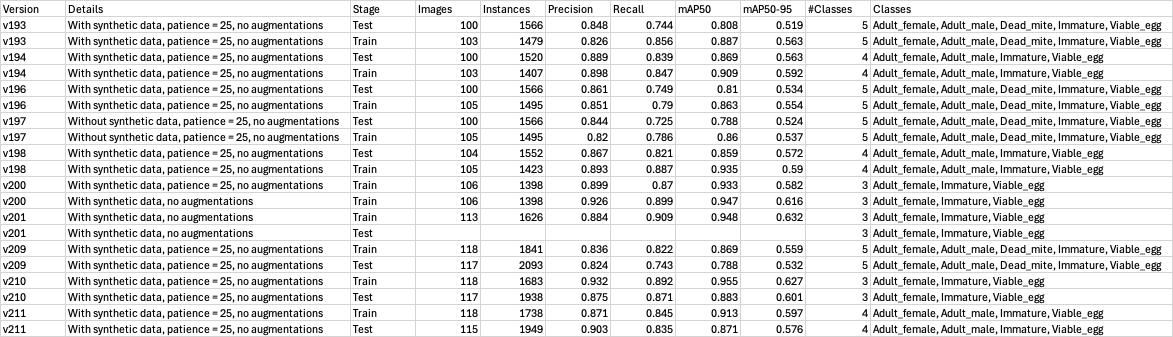

# 90:10 training set

In [11]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter

# === CONFIGURATION ===
random.seed(42)
DATASET_DIR = Path("/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-v226/train")
IMAGES_DIR = DATASET_DIR / "images"
LABELS_DIR = DATASET_DIR / "labels"
OUTPUT_DIR = Path("/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-v226/split_90_10")

TRAIN_RATIO = 0.9

# === IDENTIFY SYNTHETIC IMAGES ===
def is_synthetic(path):
    name = path.stem
    return name.startswith("image_") or name.split("_")[0].isdigit()

# === GATHER AND FILTER FILES ===
image_paths = sorted([p for p in IMAGES_DIR.glob("*.jpg")])
image_paths = [p for p in image_paths if (LABELS_DIR / (p.stem + ".txt")).exists()]
print(f"Found {len(image_paths)} valid image-label pairs.")

# Separate synthetic and real
synthetic_imgs = [p for p in image_paths if is_synthetic(p)]
real_imgs = [p for p in image_paths if not is_synthetic(p)]

print(f"Identified {len(synthetic_imgs)} synthetic images (used only in training).")

# Split only the real images into train/val
real_train, val_imgs = train_test_split(real_imgs, test_size=(1 - TRAIN_RATIO), shuffle=True, random_state=42)

# Combine synthetic with real train images
train_imgs = real_train + synthetic_imgs

# === FILE COPYING FUNCTION ===
def copy_split(image_list, split_name):
    for img_path in image_list:
        label_path = LABELS_DIR / (img_path.stem + ".txt")
        shutil.copy(img_path, OUTPUT_DIR / f"{split_name}/images" / img_path.name)
        shutil.copy(label_path, OUTPUT_DIR / f"{split_name}/labels" / label_path.name)

# === CLASS COUNT FUNCTION ===
def count_classes(label_files):
    counter = Counter()
    for lbl_path in label_files:
        with open(lbl_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    cls_id = int(parts[0])
                    counter[cls_id] += 1
    return dict(counter)

# === CREATE OUTPUT FOLDERS ===
for subdir in ["train/images", "train/labels", "val/images", "val/labels"]:
    os.makedirs(OUTPUT_DIR / subdir, exist_ok=True)

# === COPY FILES ===
print(f"\nCopying training set ({len(train_imgs)} files)...")
copy_split(train_imgs, "train")
print(f"Copying validation set ({len(val_imgs)} files)...")
copy_split(val_imgs, "valid")

# === REPORT CLASS DISTRIBUTIONS ===
train_label_paths = [LABELS_DIR / (p.stem + ".txt") for p in train_imgs]
val_label_paths = [LABELS_DIR / (p.stem + ".txt") for p in val_imgs]

print("\nClass distribution in train:", dict(sorted(count_classes(train_label_paths).items())))
print("Class distribution in val:  ", dict(sorted(count_classes(val_label_paths).items())))

print("\n✅ Done creating 90:10 train/val split (with synthetic images excluded from val).")


Found 1081 valid image-label pairs.
Identified 200 synthetic images (used only in training).

Copying training set (992 files)...
Copying validation set (89 files)...

Class distribution in train: {0: 1129, 1: 963, 2: 866, 3: 2788, 4: 9325}
Class distribution in val:   {0: 57, 1: 18, 2: 49, 3: 260, 4: 1259}

✅ Done creating 90:10 train/val split (with synthetic images excluded from val).


## Train

In [18]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-v226/split_90_10/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-v226/split_90_10/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train112, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

## Results

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:01<00:00,  2.59it/s]
                   all         89       1643      0.862       0.75      0.835      0.524
          Adult_female         47         57      0.911      0.912      0.971      0.667
            Adult_male         13         18      0.667      0.556      0.639      0.327
             Dead_mite         21         49      0.815      0.571       0.66      0.361
              Immature         37        260      0.941      0.795      0.925      0.527
            Viable_egg         83       1259      0.976      0.917      0.977      0.738
Speed: 0.3ms preprocess, 7.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train112

# v229

In [8]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-v2")
version = project.version(229)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-v2-229 in yolov11:: 100%|██████████| 2088/2088 [00:14<00:00, 143.27it/s]


In [13]:
!yolo task=detect mode=train model=yolo11l.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-229/data.yaml epochs=100 imgsz=1024 seed=42 patience=25

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-v2-229/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train147, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

### Results

In [ ]:
"""
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.26it/s]
                   all        114       1736      0.872      0.813      0.877       0.57
          Adult_female         44         56       0.91      0.902      0.943       0.63
            Adult_male         32         53      0.838      0.792      0.867      0.547
             Dead_mite         39         76      0.745      0.579      0.681      0.403
              Immature         66        417      0.911       0.86      0.921      0.538
            Viable_egg         98       1134      0.958      0.933      0.974      0.735
Speed: 0.3ms preprocess, 7.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train147
"""

#-------------SEGMENTATION-------------

# Summary of segmentation results from prev notebook

In [ ]:
"""
Performance (36 image valid set, 633 instances):
1. Google, train65, baseline + 100 hop synthetic images, 0.905, 0.857
2. Google, train66, baseline + 100 columbine synthetic images, 0.900, 0.828
3. Google, train64, baseline + 100 strawberry synthetic images, 0.899, 0.817
4. Google, train68, baseline + 25/25/25/25 split of hop/rasp/col/stb, 0.876, 0.811
5. Google, train67, baseline + 100 raspberry synthetic images, 0.876, 0.782
6. COE, train19, baseline + 25 strawberry synthetic images, 0.875, 0.792
7. COE, train17, baseline + 10 strawberry synthetic images, 0.85, 0.784
8. COE, train10, baseline + 50 strawberry synthetic images, 0.835, 0.718
9. Google, train63, baseline, 0.835, 0.77

Performance (32 image test set, 424 instances):
1. Google, train64, baseline + 100 strawberry synthetic images, 0.872, 0.813
2. Google, train65, baseline + 100 hop synthetic images, 0.851, 0.771
3. Google, train66, baseline + 100 columbine synthetic images, 0.841, 0.746
4. Google, train68, baseline + 25/25/25/25 split of hop/rasp/col/stb, 0.841, 0.746
5. Google, train63, baseline, 0.816, 0.763
6. COE, train19, baseline + 25 strawberry synthetic images, 0.814, 0.734
7. COE, train17, baseline + 10 strawberry synthetic images, 0.809, 0.741
8. COE, train10, baseline + 50 strawberry synthetic images, 0.791, 0.697
9. Google, train67, baseline + 100 raspberry synthetic images, 0.697, 0.627


Performance (Strawberry Test Set; 39 images, 360 instances):
1. Google, train67, baseline + 100 raspberry synthetic images, 0.697, 0.627
2. Google, train63, baseline, 0.682, 0.568
3. Google, train66, baseline + 100 columbine synthetic images, 0.646, 0.523
4. COE, train10, baseline + 50 strawberry synthetic images, 0.617, 0.441
5. Google, train64, baseline + 100 strawberry synthetic images, 0.599, 0.504
6. Google, train68, baseline + 25/25/25/25 split of hop/rasp/col/stb, 0.563, 0.515
7. COE, train19, baseline + 25 strawberry synthetic images, 0.524, 0.455
8. COE, train17, baseline + 10 strawberry synthetic images, 0.482, 0.453
9. Google, train65, baseline + 100 hop synthetic images, 0.465, 0.374


Performance (Raspberry Test Set; 4 images, 16 instances):
1[tie]. Google, train67, baseline + 100 raspberry synthetic images, 0.965, 0.938
1[tie]. COE, train17, baseline + 10 strawberry synthetic images, 0.965, 0.938
2. Google, train64, baseline + 100 strawberry synthetic images, 0.951, 0.906
3. Google, train66, baseline + 100 columbine synthetic images, 0.949, 0.852
4. Google, train65, baseline + 100 hop synthetic images, 0.919, 0.844
5. COE, train19, baseline + 25 strawberry synthetic images, 0.919, 0.844
6. Google, train68, baseline + 25/25/25/25 split of hop/rasp/col/stb, 0.888, 0.781
7. COE, train10, baseline + 50 strawberry synthetic images, 0.786,  0.823
8. Google, train63, baseline, [not run]



Performance (Columbine Test Set, 11 images, 81 instances):
1. Google, train63, baseline, 0.602, 0.474
2. Google, train64, baseline + 100 strawberry synthetic images, 0.418, 0.334
3. Google, train66, baseline + 100 columbine synthetic images, 0.373, 0.287
4. COE, train17, baseline + 10 strawberry synthetic images, 0.347, 0.238
5. COE, train19, baseline + 25 strawberry synthetic images, 0.342, 0.247
6. Google, train68, baseline + 25/25/25/25 split of hop/rasp/col/stb, 0.301, 0.211
7. Google, train65, baseline + 100 hop synthetic images, 0.300, 0.233
8. COE, train10, baseline + 50 strawberry synthetic images, 0.288, 0.181

8. Google, train67, baseline + 100 raspberry synthetic images, [not run]




#Explore why improvement is so spotty with synthetic data

Next I sampled the synthetic segmentation images with the most annotations (top 10) and decided to add those to the baseline v96 training set to see if perhaps overfitting is the issue with some of the other host data (since I was limited to ~5 background images for each host... maybe the model was memorizing artifacts in thebackground).

### Subsample synthetic script

In [ ]:
import os
import argparse
import shutil


def count_annotations(label_file):
    """Count non-empty lines (annotations) in a label file."""
    count = 0
    with open(label_file, 'r') as f:
        for line in f:
            if line.strip():
                count += 1
    return count


def main(args):
    # Directories for input labels and images
    labels_dir = args.labels_dir
    images_dir = args.images_dir
    # Directories to save the subsampled labels and images
    out_labels_dir = args.out_labels_dir
    out_images_dir = args.out_images_dir

    os.makedirs(out_labels_dir, exist_ok=True)
    os.makedirs(out_images_dir, exist_ok=True)

    # Get all .txt files in the labels directory
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

    # Create a list of tuples: (filename, annotation_count)
    annotation_list = []
    for label_file in label_files:
        full_path = os.path.join(labels_dir, label_file)
        count = count_annotations(full_path)
        annotation_list.append((label_file, count))

    # Sort files by annotation count in descending order
    annotation_list.sort(key=lambda x: x[1], reverse=True)

    # Subsample the top N samples
    selected = annotation_list[:args.num_samples]

    print("Selected samples (filename, annotation count):")
    for fname, count in selected:
        print(f"  {fname}: {count}")

    # Copy selected label and corresponding image files to output folders
    for label_fname, count in selected:
        # Copy label file
        src_label = os.path.join(labels_dir, label_fname)
        dst_label = os.path.join(out_labels_dir, label_fname)
        shutil.copy2(src_label, dst_label)

        # Corresponding image: assume same basename but .jpg extension
        image_fname = os.path.splitext(label_fname)[0] + '.jpg'
        src_image = os.path.join(images_dir, image_fname)
        dst_image = os.path.join(out_images_dir, image_fname)
        if os.path.exists(src_image):
            shutil.copy2(src_image, dst_image)
        else:
            print(f"Warning: Image file not found for {label_fname}: expected {src_image}")

    print(f"\nCopied {len(selected)} samples to '{out_labels_dir}' and '{out_images_dir}'.")


if __name__ == '__main__':
    parser = argparse.ArgumentParser(
        description="Subsample the images and labels with the most annotations."
    )
    parser.add_argument(
        "--labels_dir",
        type=str,
        default="/Users/michelewiseman/Downloads/synthetic_images/train/strawberry_labels",
        help="Directory containing label .txt files (in polygon Roboflow format)"
    )
    parser.add_argument(
        "--images_dir",
        type=str,
        default="/Users/michelewiseman/Downloads/synthetic_images/train/strawberry_images",
        help="Directory containing image files (.jpg)"
    )
    parser.add_argument(
        "--out_labels_dir",
        type=str,
        default="/Users/michelewiseman/Downloads/synthetic_images/strawberry_subset_labels",
        help="Output directory for selected label files"
    )
    parser.add_argument(
        "--out_images_dir",
        type=str,
        default="/Users/michelewiseman/Downloads/synthetic_images/strawberry_subset_images",
        help="Output directory for selected image files"
    )
    parser.add_argument(
        "--num_samples",
        type=int,
        default=10,
        help="Number of samples to subsample (top ones with the most annotations)"
    )

    args = parser.parse_args()
    main(args)


## +10 strawberry image

In [ ]:
"""
yolo task=segment mode=train model=yolo11l-seg.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Segmentation-v96/data.yaml epochs=100 imgsz=1024 patience=25 seed=42 batch=32 workers=1

YOLO11l-seg summary (fused): 491 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]
                   all         36        633      0.852      0.784       0.85       0.58      0.811      0.807      0.843      0.509
          Adult_female         21         28      0.863      0.897      0.966      0.694      0.866      0.924      0.966      0.718
            Adult_male         16         25      0.847      0.667      0.825      0.466      0.746      0.707      0.825      0.523
             Dead_mite         16         27      0.778      0.593       0.64      0.426      0.769      0.667      0.688      0.464
              Immature         28        146      0.789      0.842      0.847      0.532      0.767      0.877      0.869      0.475
            Viable_egg         31        407      0.984      0.924      0.973      0.783      0.906       0.86      0.869      0.364
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/train17


In [ ]:
"""
yolo task=segment mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/segment/train17/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Segmentation-v96/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42
yolo task=segment mode=val model=/nfs/stak/users/wisemami/scratch_space/TSSM/runs/segment/train17/weights/best.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/segmentation_test_sets/raspberry/data.yaml show_labels=False conf=0.5 line_width=2 imgsz=1024 seed=42


In [ ]:
"""
test set
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.48s/it]
                   all         32        424      0.839      0.741      0.809      0.606      0.815      0.719       0.79      0.474
          Adult_female         18         19      0.778      0.737      0.839      0.607      0.778      0.737      0.839      0.648
            Adult_male         14         27      0.833      0.741      0.823      0.626      0.833      0.741      0.817      0.495
             Dead_mite         15         25      0.789        0.6      0.643      0.441      0.789        0.6      0.691      0.398
              Immature         20        123      0.835       0.74      0.806      0.581      0.807      0.715       0.79      0.481
            Viable_egg         30        230      0.958      0.887      0.934      0.777      0.869      0.804      0.813      0.348
Speed: 0.2ms preprocess, 49.4ms inference, 0.0ms loss, 16.3ms postprocess per image

## + 25 strawberry images

## +50 strawberry images

In [ ]:
"""
yolo task=segment mode=train model=yolo11l-seg.pt data=/nfs/stak/users/wisemami/scratch_space/TSSM/TSSM-Segmentation-v96/data.yaml epochs=100 imgsz=1024 patience=25 seed=42 batch=32 workers=1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it
                   all         36        633      0.886      0.718      0.835      0.572      0.892      0.712      0.826      0.486
          Adult_female         21         28      0.828      0.861       0.94      0.682      0.828      0.859       0.94        0.7
            Adult_male         16         25      0.886       0.68      0.811      0.501      0.887       0.68      0.811      0.497
             Dead_mite         16         27      0.829      0.333      0.554       0.34      0.924       0.37      0.617       0.38
              Immature         28        146      0.893      0.795       0.89      0.557      0.906      0.801      0.894      0.504
            Viable_egg         31        407      0.992       0.92      0.978      0.781      0.914      0.848      0.867       0.35
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/segment/train10


### Test

In [ ]:
"""
 ####### REGULAR TEST SET #######
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.87s/
                   all         32        424      0.873      0.697      0.791      0.566      0.847      0.669      0.764      0.457
          Adult_female         18         19      0.739      0.895       0.81      0.525      0.696      0.842      0.785      0.585
            Adult_male         14         27      0.889      0.593      0.752      0.563      0.889      0.593      0.752      0.492
             Dead_mite         15         25        0.9       0.36      0.624      0.372        0.9       0.36      0.624      0.358
              Immature         20        123      0.892       0.74      0.836      0.599      0.902      0.748      0.842      0.516
            Viable_egg         30        230      0.945      0.896      0.936      0.771      0.849      0.804      0.818      0.336
Speed: 0.2ms preprocess, 49.5ms inference, 0.0ms loss, 19.9ms postprocess per image
Results saved to runs/segment/val11

 ####### STRAWBERRY TEST SET #######                                                                                                                                                           val: Scanning /nfs/hpc/share/wisemami/TSSM/segmentation_test_sets/strawberry/valid/labels.cache... 39 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<?, ?it/s]
/nfs/stak/users/wisemami/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it
                   all         39        360       0.79      0.441      0.617      0.448      0.748      0.408      0.567      0.253
          Adult_female          8         10          1        0.4        0.7      0.472          1        0.4        0.7      0.474
            Adult_male          2          2          0          0          0          0          0          0          0          0
             Dead_mite          2          2          1        0.5       0.75        0.6          1        0.5       0.75       0.15
              Immature         22         42      0.957      0.524      0.743      0.494      0.957      0.524      0.743       0.43
            Viable_egg         38        304      0.996      0.783       0.89      0.675      0.782      0.615      0.642      0.214
Speed: 20.1ms preprocess, 26.9ms inference, 0.0ms loss, 8.2ms postprocess per image
Results saved to runs/segment/val12

 ####### RASPBERRY TEST SET #######

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it
                   all          4         16      0.875      0.823      0.786      0.444       0.72      0.698       0.65      0.318
          Adult_female          2          3          1      0.667      0.833        0.2          1      0.667      0.833      0.417
             Dead_mite          2          4          1       0.75      0.875      0.504      0.667        0.5      0.582      0.407
              Immature          1          1        0.5          1      0.497      0.398        0.5          1      0.497      0.348
            Viable_egg          4          8          1      0.875      0.937      0.673      0.714      0.625      0.687      0.102
Speed: 1.3ms preprocess, 37.3ms inference, 0.0ms loss, 20.4ms postprocess per image
Results saved to runs/segment/val13

 ####### COLUMBINE TEST SET #######

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it
                   all         11         81      0.389      0.181      0.288      0.198      0.311      0.143      0.232      0.105
          Adult_female          1          1          0          0          0          0          0          0          0          0
            Adult_male          1          1          0          0          0          0          0          0          0          0
             Dead_mite          5         11          0          0          0          0          0          0          0          0
              Immature         10         40          1        0.3       0.65      0.385      0.833       0.25      0.545      0.322
            Viable_egg          6         28      0.944      0.607      0.789      0.605      0.722      0.464      0.616      0.205
Speed: 0.5ms preprocess, 37.2ms inference, 0.0ms loss, 35.1ms postprocess per image
Results saved to runs/segment/val14


# v97 100 hop synthetic images + augmentation

vh flip, includes other host data (but not other host synthetic data)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(97)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 48.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-97 in yolov11:: 100%|██████████| 1370/1370 [00:10<00:00, 126.48it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-97/data.yaml epochs=100 imgsz=1024 batch=16 seed=42 patience=25

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-97/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train69, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

## Results

Oddly worse than before, but pretty much only because of the dead mite class. All other classes did really well.

In [ ]:
"""
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  2.66it/s]
                   all         39        646       0.85       0.78      0.859      0.582      0.844      0.796      0.859      0.514
          Adult_female         22         29      0.957      0.768      0.941      0.653      0.958       0.78      0.941      0.721
            Adult_male         18         27      0.775      0.889        0.9      0.575      0.799      0.926       0.92      0.551
             Dead_mite         16         27        0.7      0.556      0.617      0.385      0.692      0.593      0.646      0.377
              Immature         30        148      0.828      0.831      0.871      0.543      0.828      0.848      0.872      0.522
            Viable_egg         33        415      0.989      0.854      0.965      0.756      0.945      0.831      0.914      0.397
Speed: 0.3ms preprocess, 7.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train69

## Test Set

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train69/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-101/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-101/valid/labels.cache... 34 images, 0 backgrounds, 0 corrupt: 100% 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:08<00:00,  2.84s/it]
                   all         34        429      0.846      0.723      0.793      0.578      0.838      0.713      0.793      0.479
          Adult_female         19         20      0.875        0.7      0.821      0.583      0.938       0.75      0.867      0.624
            Adult_male         16         29      0.786      0.759      0.778      0.576      0.714       0.69      0.722      0.491
             Dead_mite         15         25        0.7   

#v100 hop synthetic images + 56 other host images

In 156 synthetic images:
* Viable_egg: 401
* Adult_male: 359
* Adult_female: 330
* Immature: 326
* Dead_mite: 293

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(100)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-100 in yolov11:: 100%|██████████| 862/862 [00:06<00:00, 132.48it/s]


## Train

In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-100/data.yaml epochs=100 imgsz=1024 batch=16 seed=42 patience=25

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-100/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train70, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

## Results

In [ ]:
"""
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 59, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

84 epochs completed in 0.316 hours.
Optimizer stripped from runs/segment/train70/weights/last.pt, 55.9MB
Optimizer stripped from runs/segment/train70/weights/best.pt, 55.9MB

Validating runs/segment/train70/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  2.67it/s]
                   all         39        646      0.899       0.75      0.866      0.584      0.891      0.743      0.848      0.501
          Adult_female         22         29      0.919      0.782      0.941       0.69      0.919      0.781      0.941      0.701
            Adult_male         18         27      0.792      0.815      0.831      0.544      0.792      0.815      0.831      0.479
             Dead_mite         16         27      0.939      0.593      0.736      0.407       0.94      0.593      0.736      0.431
              Immature         30        148      0.861      0.792      0.877      0.536       0.86      0.792      0.862      0.514
            Viable_egg         33        415      0.987      0.769      0.943      0.744      0.944      0.735      0.868       0.38
Speed: 0.3ms preprocess, 7.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/train70
💡 Learn more at https://docs.ultralytics.com/modes/train

## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train70/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-101/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-101/valid/labels.cache... 34 images, 0 backgrounds, 0 corrupt: 100% 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:08<00:00,  2.76s/it]
                   all         34        429      0.837      0.744      0.803      0.565      0.831      0.736      0.793      0.478
          Adult_female         19         20      0.842        0.8      0.837      0.545      0.842        0.8      0.837      0.612
            Adult_male         16         29       0.71      0.759       0.74      0.555       0.71      0.759      0.732      0.482
             Dead_mite         15         25      0.737   

#v101 retest just the 100 hop synthetic image addition

I'm surprised to see worse performance, but it could be due to the other hosts or the other host synthetic images. Alas, I'll remove other hosts again and their synthetic images and try to reproduce the earlier results.

312 images; 240 train, 38 val, 34 test

* Viable_egg 1459
* Immature 909
* Adult_male 360
* Adult_female 304
* Dead_mite 280

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(101)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Generating version still in progress. Progress: 96.15%
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-101 in yolov11:: 100%|██████████| 636/636 [00:16<00:00, 39.55it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-101/data.yaml epochs=100 imgsz=1024 batch=16 seed=42 patience=25

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-101/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train71, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

## Results

In [ ]:
"""
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 73, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

98 epochs completed in 0.324 hours.
Optimizer stripped from runs/segment/train71/weights/last.pt, 55.9MB
Optimizer stripped from runs/segment/train71/weights/best.pt, 55.9MB

Validating runs/segment/train71/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.34it/s]
                   all         38        644      0.846      0.844      0.892      0.624      0.822      0.824      0.859      0.517
          Adult_female         21         28      0.839      0.964      0.982      0.698      0.839      0.964      0.982      0.752
            Adult_male         18         27      0.852      0.853      0.903      0.589      0.852      0.853      0.889      0.535
             Dead_mite         15         30      0.816      0.591      0.703      0.488       0.77      0.558      0.677      0.446
              Immature         29        148      0.764      0.905      0.903      0.571       0.77      0.912      0.908      0.527
            Viable_egg         32        411      0.959      0.908      0.971      0.775      0.877       0.83      0.838      0.322
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/train71

## Test

Need to delete labels cache otherwise you'll get an error.

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train71/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-101/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-101/valid/labels.cache... 34 images, 0 backgrounds, 0 corrupt: 100% 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:08<00:00,  2.74s/it]
                   all         34        429      0.873      0.732       0.83      0.614      0.872      0.718      0.816      0.512
          Adult_female         19         20      0.855       0.85      0.901      0.629      0.856       0.85      0.901      0.703
            Adult_male         16         29      0.913      0.724      0.832      0.643      0.913      0.724      0.832      0.595
             Dead_mite         15         25      0.709   

Fixed a few annotations, lets try again. Overall pretty darn good but would like to improve dead_mite class.

#v102 fixed a few annotations and swapped a few val/train images

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(102)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-102 in yolov11:: 100%|██████████| 634/634 [00:15<00:00, 41.90it/s]


## Train

In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train75, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
100 epochs completed in 0.324 hours.
Optimizer stripped from runs/segment/train75/weights/last.pt, 55.9MB
Optimizer stripped from runs/segment/train75/weights/best.pt, 55.9MB

Validating runs/segment/train75/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.23it/s]
                   all         39        655      0.839      0.821      0.853      0.598       0.84      0.808      0.839      0.504
          Adult_female         20         26      0.801      0.923      0.933      0.644      0.805      0.923      0.933      0.682
            Adult_male         21         31      0.808      0.816      0.827       0.55      0.808      0.806      0.827      0.536
             Dead_mite         15         32      0.799      0.531       0.62      0.426      0.857      0.562      0.672      0.406
              Immature         29        152      0.824      0.895      0.916      0.584      0.835      0.882      0.909      0.552
            Viable_egg         32        414      0.965       0.94       0.97      0.786      0.893      0.867      0.856      0.346
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/train75
💡 Learn more at https://docs.ultralytics.com/modes/train

## Inference

In [ ]:
!yolo task=segment mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train75/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/valid/images/ imgsz=1024 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs

image 1/39 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/valid/images/004-citra_mites_jpg.rf.bfea97e81f47480babbd4e3c603d08b6.jpg: 704x1024 1 Adult_male, 1 Immature, 73.1ms
image 2/39 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/valid/images/004-nugget_mites_png.rf.1b38dfed15aa4fc13e80bd58f9710b51.jpg: 704x1024 1 Adult_female, 2 Immatures, 19 Viable_eggs, 20.0ms
image 3/39 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/valid/images/005-mites_6_27_png.rf.f36b990cb70c152b15b6d1d16994d610.jpg: 704x1024 2 Adult_females, 1 Adult_male, 1 Immature, 21 Viable_eggs, 21.4ms
image 4/39 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/valid/images/0

## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train75/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/data.yaml conf=0.5 imgsz=1024 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/valid/labels... 34 images, 0 backgrounds, 0 corrupt: 100% 34/34 [00:00<00:00, 204.26it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-102/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:08<00:00,  2.82s/it]
                   all         34        429      0.912      0.755      0.849      0.626      0.878      0.711      0.814      0.524
          Adult_female         19         20      0.822       0.85      0.893      0.619      0.805        0.8      0.851      0.684
            Adult_male         16         29      0.955 

val: 0.853 and test: 0.849. Nice!

I looked at inference results and the model thinks a few of my juveniles are adult males and vice-versa...most of them are ones I wasnt sure about... so I went with the models highest confidence. A few dead mites it missed I think are beyond dead mite recognition, so I removed them from the class. I think it's only possible reliably train the model to detec recently dead mites rather than long-dead.

#v104 fixed a few more annotations; just real images + 100 hop syn images.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(104)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Generating version still in progress. Progress: 97.43%
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-104 in yolov11:: 100%|██████████| 634/634 [00:15<00:00, 41.69it/s]


## Train

In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train76, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
Validating runs/segment/train76/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.08it/s]
                   all         40        661      0.858      0.826      0.881      0.619      0.828      0.801       0.84      0.514
          Adult_female         21         27      0.736      0.889       0.91      0.686      0.737      0.889       0.91      0.686
            Adult_male         22         34      0.846      0.824      0.902      0.599      0.846      0.824       0.91      0.597
             Dead_mite         16         25      0.886      0.623      0.709      0.471      0.829      0.583      0.641      0.428
              Immature         29        156       0.84      0.874      0.911      0.554      0.834      0.868      0.899      0.522
            Viable_egg         33        419      0.981      0.921      0.971      0.783      0.895       0.84      0.838      0.339
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train76

## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train76/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/valid/labels... 34 images, 0 backgrounds, 0 corrupt: 100% 34/34 [00:00<00:00, 210.56it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:08<00:00,  2.89s/it]
                   all         34        429      0.862      0.737      0.811      0.607      0.865      0.737      0.808       0.51
          Adult_female         19         20      0.696        0.8      0.787      0.571      0.739       0.85      0.812      0.641
            Adult_male         16         29      0.913 

valid: 0.881, 0.826
test: 0.811, 0.737

In [ ]:
!yolo task=segment mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train76/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/valid/images/ imgsz=1024 conf=0.5 show_labels=False seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs

image 1/34 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/valid/images/001-mites_6_27_png.rf.e1831bc393421b1b431b471f1804b735.jpg: 704x1024 2 Adult_females, 1 Immature, 16 Viable_eggs, 73.6ms
image 2/34 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/valid/images/003-manual-stack-copy_jpeg_jpg.rf.35d37bab9852601ac79074ec34f6d340.jpg: 704x1024 1 Adult_male, 21.1ms
image 3/34 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/valid/images/003-mite_png.rf.042853ee4999cdee1ca783fc4e94faac.jpg: 704x1024 1 Adult_female, 1 Dead_mite, 2 Viable_eggs, 20.0ms
image 4/34 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-104/valid/images/004-citra_mites_1_jpg.rf.

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train76/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train76/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train76/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set/valid/labels.cache... 39 images, 0 backgrounds, 0 corrupt: 100% 39/39 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.23s/it]
                   all         39        360      0.603      0.499      0.533      0.388      0.569       0.47       0.49      0.249
          Adult_female          8         10      0.667        0.6      0.645        0.4      0.667        0.6      0.645      0.434
            Adult_male          2          2          0          0          0          0          0          0          0          0
             Dead_mite          2          2        0.5        0.5      0.375  

#v105 fixed a few more annotations

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(105)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Generating version still in progress. Progress: 97.11%
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-105 in yolov11:: 100%|██████████| 634/634 [00:15<00:00, 40.21it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-105/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-105/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train77, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

Why is this worse?

In [ ]:
"""
100 epochs completed in 0.329 hours.
Optimizer stripped from runs/segment/train77/weights/last.pt, 55.9MB
Optimizer stripped from runs/segment/train77/weights/best.pt, 55.9MB

Validating runs/segment/train77/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.10it/s]
                   all         40        661       0.85      0.783      0.863      0.614      0.835      0.768      0.844      0.518
          Adult_female         21         27      0.842      0.926      0.967      0.693      0.842      0.926      0.967      0.733
            Adult_male         22         34      0.849      0.824      0.853      0.624      0.849      0.824       0.87       0.56
             Dead_mite         16         25      0.756        0.4      0.619      0.441      0.757        0.4      0.622       0.41
              Immature         29        156      0.837      0.827      0.899      0.544      0.825      0.814      0.888      0.518
            Viable_egg         33        419      0.968       0.94      0.977      0.768      0.902      0.874      0.872       0.37
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train77
💡 Learn more at https://docs.ultralytics.com/modes/train

## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train77/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-105/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-105/valid/labels... 35 images, 0 backgrounds, 0 corrupt: 100% 35/35 [00:00<00:00, 199.16it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-105/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:08<00:00,  2.78s/it]
                   all         35        439      0.879       0.75      0.847      0.647      0.851       0.72      0.818      0.518
          Adult_female         18         18      0.727      0.889       0.89      0.683      0.682      0.833      0.854       0.67
            Adult_male         16         30      0.957 

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train77/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-105/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train77/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train77/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train77/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set/valid/labels.cache... 39 images, 0 backgrounds, 0 corrupt: 100% 39/39 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.25s/it]
                   all         39        360      0.529      0.404      0.473       0.33      0.488      0.369      0.423      0.224
          Adult_female          8         10       0.75        0.6       0.69      0.426       0.75        0.6       0.69      0.442
            Adult_male          2          2          0          0          0          0          0          0          0          0
             Dead_mite          2          2          0          0          0  

#v106 same as 105 but without dead mite class

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(106)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-106 in yolov11:: 100%|██████████| 634/634 [00:15<00:00, 41.21it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train78, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
100 epochs completed in 0.327 hours.
Optimizer stripped from runs/segment/train78/weights/last.pt, 55.9MB
Optimizer stripped from runs/segment/train78/weights/best.pt, 55.9MB

Validating runs/segment/train78/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,587,676 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.22it/s]
                   all         40        636      0.879      0.883      0.919      0.659      0.856      0.859      0.885      0.528
          Adult_female         21         27      0.958      0.844      0.947      0.681      0.958      0.843      0.947      0.726
            Adult_male         22         34      0.829      0.853      0.874      0.615      0.828      0.852      0.874      0.549
              Immature         29        156      0.767      0.884      0.875      0.541      0.761      0.877      0.867      0.506
            Viable_egg         33        419      0.964       0.95       0.98        0.8      0.877      0.864      0.851      0.331
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/train78
💡 Learn more at https://docs.ultralytics.com/modes/train

In [ ]:
!yolo task=segment mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train78/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/valid/images/ imgsz=1024 conf=0.5 show_labels=False seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,587,676 parameters, 0 gradients, 141.9 GFLOPs

image 1/40 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/valid/images/004-citra_mites_jpg.rf.d39713628507d615188e0d5705d58d15.jpg: 704x1024 1 Adult_male, 2 Immatures, 80.7ms
image 2/40 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/valid/images/004-nugget_mites_png.rf.4acb88d669897014d75779080033c29a.jpg: 704x1024 1 Adult_female, 2 Immatures, 19 Viable_eggs, 20.4ms
image 3/40 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/valid/images/005-mites_6_27_png.rf.1eba7bf97559f221fe3b10add5781b11.jpg: 704x1024 2 Adult_females, 1 Immature, 21 Viable_eggs, 20.4ms
image 4/40 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/valid/images/005-nugget_mit

## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train78/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,587,676 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/valid/labels... 35 images, 0 backgrounds, 0 corrupt: 100% 35/35 [00:00<00:00, 216.11it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-106/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:08<00:00,  2.87s/it]
                   all         35        413      0.926      0.785      0.877      0.687       0.91       0.77      0.855      0.535
          Adult_female         18         18      0.964      0.833      0.912      0.703      0.964      0.833      0.912      0.697
            Adult_male         16         30      0.902 

## Other hosts

#v111 no synthetic, no other hosts, no augmentations (baseline)



Classes: Adult female, Adult male, Dead mite, Immature, and Viable egg

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(111)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Generating version still in progress. Progress: 99.05%
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-111 in yolov11:: 100%|██████████| 434/434 [00:09<00:00, 46.76it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-111/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-111/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train79, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
Validating runs/segment/train79/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.04it/s]
                   all         40        671      0.765      0.782      0.833      0.565      0.785      0.752      0.812      0.463
          Adult_female         21         27      0.691      0.913      0.935       0.68      0.698      0.889      0.935      0.691
            Adult_male         22         34      0.774      0.703      0.808      0.503      0.799      0.676      0.808      0.476
             Dead_mite         16         32       0.75      0.468      0.575      0.357      0.885      0.482      0.634      0.351
              Immature         29        158      0.695      0.873      0.874       0.52      0.715      0.861      0.873      0.486
            Viable_egg         33        420      0.913      0.952      0.975      0.762      0.827       0.85      0.813      0.312
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train79
"""

## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train79/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train79/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train79/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train79/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/valid/labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.13s/it]
                   all         42        555      0.818      0.675       0.75      0.553      0.801      0.644      0.728      0.405
          Adult_female         21         23      0.645       0.87      0.768      0.525      0.613      0.826      0.743      0.538
            Adult_male         17         31      0.789      0.484       0.63      0.483      0.737      0.452      0.601       0.38
             Dead_mite         19         29      0.889   

#v112 no synthetic, but with other hosts, no augmentations

Classes: Adult female, Adult male, Dead mite, Immature, and Viable egg

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(112)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-112 in yolov11:: 100%|██████████| 548/548 [00:12<00:00, 42.18it/s]


## Train

In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-112/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-112/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train80, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.00it/s]
                   all         40        671      0.889       0.81      0.865      0.583      0.864      0.785      0.825      0.485
          Adult_female         21         27      0.801      0.926      0.959      0.661      0.801      0.926      0.959      0.717
            Adult_male         22         34      0.824      0.824       0.84       0.54      0.827      0.824       0.84      0.495
             Dead_mite         16         32          1      0.512      0.686      0.393          1      0.511      0.673      0.388
              Immature         29        158      0.847      0.848      0.867      0.523      0.835      0.835      0.845      0.485
            Viable_egg         33        420      0.974       0.94      0.976      0.797      0.859      0.829      0.807      0.339
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train80
💡 Learn more at https://docs.ultralytics.com/modes/train
"""


## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train80/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/valid/labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.25s/it]
                   all         42        555      0.866      0.709      0.813      0.617      0.843      0.667       0.77      0.462
          Adult_female         21         23      0.714       0.87      0.896      0.655      0.679      0.826      0.851      0.633
            Adult_male         17         31       0.88       0.71      0.801      0.594        0.8      0.645      0.738      0.498
             Dead_mite         19         29      0.857   

#v113 with hop synthetic only (no other hosts)

Classes: Adult female, Adult male, Dead mite, Immature, and Viable egg

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(113)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-113 in yolov11:: 100%|██████████| 634/634 [00:15<00:00, 40.87it/s]


## Train

In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-113/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-113/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train81, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.18it/s]
                   all         40        671       0.94      0.753      0.863      0.612      0.929      0.736       0.83      0.512
          Adult_female         21         27      0.959      0.861      0.953        0.7      0.959      0.859      0.953      0.738
            Adult_male         22         34       0.92      0.794      0.908      0.623      0.924      0.794      0.908      0.593
             Dead_mite         16         32      0.953      0.375      0.574      0.372      0.971      0.375      0.558      0.373
              Immature         29        158      0.892      0.816      0.905      0.571      0.892       0.81      0.878      0.513
            Viable_egg         33        420      0.978      0.919      0.974      0.792        0.9      0.843      0.852      0.341
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/train81

## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/strawberry_test_set/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/raspberry_test_set/data.yaml conf=0.5 imgsz=1024
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/columbine_test_set/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/valid/labels... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<00:00, 106.46it/s]
val: New cache created: /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.10s/it]
                   all         42        555      0.918      0.762       0.86      0.676        0.9      0.745      0.836      0.537
          Adult_female         21         23      0.917       0.87       0.91        0.7      0.916       0.87       0.91        0.7
            Adult_male         17         31      0.889 

#v114 Synthetic hop and other host (real) data

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(114)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-114 in yolov11:: 100%|██████████| 748/748 [00:19<00:00, 39.24it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-114/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-114/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train82, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  2.87it/s]
                   all         40        671      0.919      0.778      0.871      0.612      0.901      0.763      0.838      0.506
          Adult_female         21         27      0.913      0.889      0.964        0.7       0.91      0.889      0.964       0.73
            Adult_male         22         34      0.924      0.794      0.871      0.585      0.923      0.794      0.871      0.544
             Dead_mite         16         32      0.922      0.438      0.635      0.414      0.919      0.438      0.612      0.389
              Immature         29        158      0.863      0.829      0.906      0.563      0.865      0.842       0.91      0.529
            Viable_egg         33        420      0.974      0.938      0.978        0.8      0.887      0.855      0.834      0.337
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train82


## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/valid/labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.04s/it]
                   all         42        555      0.918      0.762       0.86      0.676        0.9      0.745      0.836      0.537
          Adult_female         21         23      0.917       0.87       0.91        0.7      0.916       0.87       0.91        0.7
            Adult_male         17         31      0.889      0.774      0.862      0.683      0.889      0.774      0.862      0.603
             Dead_mite         19         29      0.923   

#v115 Synthetic hop, other real host data, synthetic columbine, and synthetic strawberry; no augmentations

Classes: Adult female, Adult male, Dead mite, Immature, and Viable egg

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(115)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-115 in yolov11:: 100%|██████████| 784/784 [00:19<00:00, 40.00it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train83, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  2.72it/s]
                   all         40        671      0.868      0.807      0.871      0.615       0.85      0.789      0.844      0.498
          Adult_female         21         27      0.925      0.912      0.968      0.707      0.925      0.912      0.968      0.733
            Adult_male         22         34      0.864      0.794      0.871      0.615      0.864      0.794      0.897      0.529
             Dead_mite         16         32      0.718        0.5      0.625      0.396      0.718        0.5      0.605      0.359
              Immature         29        158      0.857       0.88      0.919      0.571      0.851      0.873      0.898      0.527
            Viable_egg         33        420      0.977      0.948      0.973      0.787      0.891      0.864      0.855       0.34
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/train83
"""

essentially comparable to 114, though better recall.

## Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train81/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/valid/labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.25s/it]
                   all         42        555      0.918      0.762       0.86      0.676        0.9      0.745      0.836      0.537
          Adult_female         21         23      0.917       0.87       0.91        0.7      0.916       0.87       0.91        0.7
            Adult_male         17         31      0.889      0.774      0.862      0.683      0.889      0.774      0.862      0.603
             Dead_mite         19         29      0.923   

#v116 all data (minus things tagged as "uncertain")

Classes: Adult female, Adult male, Dead mite, Immature, and Viable egg

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(116)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-116 in yolov11:: 100%|██████████| 860/860 [00:22<00:00, 37.64it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-116/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-116/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train84, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  2.89it/s]
                   all         40        671      0.917      0.796      0.885       0.62      0.908      0.784      0.856      0.522
          Adult_female         21         27      0.934      0.889      0.952      0.705      0.935      0.889      0.952      0.708
            Adult_male         22         34      0.826      0.853      0.901      0.606      0.856      0.882      0.902      0.577
             Dead_mite         16         32      0.966      0.438      0.683      0.444      0.972      0.438      0.673      0.422
              Immature         29        158      0.874      0.861      0.908      0.569      0.858      0.841      0.871      0.524
            Viable_egg         33        420      0.987      0.938      0.979      0.778      0.917      0.871      0.881      0.382
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train84

"""

### Test

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train84/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/valid/labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.05s/it]
                   all         42        555      0.903      0.807      0.868      0.674      0.879      0.784      0.841      0.521
          Adult_female         21         23      0.913      0.913      0.947      0.748       0.87       0.87      0.912      0.692
            Adult_male         17         31      0.818      0.871      0.822      0.656      0.818      0.871      0.822      0.582
             Dead_mite         19         29      0.938   

In [ ]:
!yolo task=segment mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train84/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-116/valid/images/ imgsz=1024 seed=42 show_labels=True line_width=2
!yolo task=segment mode=predict model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train84/weights/best.pt source=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-116/test/images/ imgsz=1024 seed=42 show_labels=True line_width=2

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs

image 1/40 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-116/valid/images/004-citra_mites_jpg.rf.23feead414b5a58dc2025486423f6535.jpg: 704x1024 1 Adult_male, 1 Immature, 80.7ms
image 2/40 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-116/valid/images/004-nugget_mites_png.rf.d0bae0d7f8efb89ed84f148001b429fe.jpg: 704x1024 1 Adult_female, 3 Immatures, 19 Viable_eggs, 24.9ms
image 3/40 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-116/valid/images/005-mites_6_27_png.rf.2577c0d32def60f4ff5dd709b4eca946.jpg: 704x1024 2 Adult_females, 1 Adult_male, 21 Viable_eggs, 20.3ms
image 4/40 /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-116/valid/images/005-nugget_mi

In [ ]:
import ultralytics
ultralytics.checks()
import roboflow
import torch

from roboflow import Roboflow
rf = Roboflow(api_key="")

project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(116)
version.deploy("yolov11", "/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train84/") #auto-appends weights/best.pt to model_path

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 39.3/235.7 GB disk)
loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/gent-lab/tssm-detection-instance-segmentation/116
Share your model with the world at: https://universe.roboflow.com/gent-lab/tssm-detection-instance-segmentation/model/116


#v117 adding vertical and horizontal flip augmentation (x2 output)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(117)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Generating version still in progress. Progress: 99.56%
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-117 in yolov11:: 100%|██████████| 1356/1356 [00:10<00:00, 132.92it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-117/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-117/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train85, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

In [ ]:
"""
Validating runs/segment/train85/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  3.28it/s]
                   all         40        671      0.883      0.769      0.862      0.609      0.864      0.752       0.83      0.511
          Adult_female         21         27      0.917      0.889      0.958      0.696      0.917      0.889      0.958      0.724
            Adult_male         22         34      0.844      0.735      0.833      0.569      0.844      0.735      0.833       0.54
             Dead_mite         16         32       0.82      0.469       0.67      0.438       0.82      0.469      0.657      0.416
              Immature         29        158      0.843      0.835      0.873      0.554      0.843      0.835      0.871      0.514
            Viable_egg         33        420       0.99      0.918      0.974      0.788      0.897      0.833      0.832      0.361
Speed: 0.2ms preprocess, 4.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train85
💡 Learn more at https://docs.ultralytics.com/modes/train

no improvement

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train85/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,588,447 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-115/valid/labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.06s/it]
                   all         42        555      0.879      0.801      0.864      0.661      0.849      0.771      0.827      0.498
          Adult_female         21         23      0.815      0.957      0.922      0.716      0.778      0.913      0.898      0.661
            Adult_male         17         31      0.694      0.806        0.8      0.631      0.694      0.806      0.803      0.537
             Dead_mite         19         29          1   

slight test improvement

#v118 (same as v116 but with no dead mite class)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(118)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Generating version still in progress. Progress: 99.06%
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to TSSM-Detection-Instance-Segmentation-118 in yolov11:: 100%|██████████| 860/860 [00:22<00:00, 38.39it/s]


In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-118/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-118/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train86, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

## Results

In [ ]:
"""
Validating runs/segment/train86/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,587,676 parameters, 0 gradients, 141.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  2.94it/s]
                   all         40        639      0.899      0.889      0.923      0.674      0.879       0.87      0.894      0.548
          Adult_female         21         27      0.856      0.883      0.933      0.717      0.856      0.883      0.933      0.732
            Adult_male         22         34      0.898      0.853      0.883      0.638      0.899      0.853      0.883       0.57
              Immature         29        158      0.871      0.873      0.899      0.562      0.871      0.873      0.893      0.525
            Viable_egg         33        420      0.969      0.945      0.975      0.778      0.891      0.869      0.867      0.364
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train86


In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train86/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-118/data.yaml conf=0.5 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,587,676 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-118/valid/labels.cache... 40 images, 1 backgrounds, 0 corrupt: 100% 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.28s/it]
                   all         40        639      0.926      0.838      0.905      0.691        0.9      0.815      0.874      0.545
          Adult_female         21         27      0.917      0.815      0.896      0.706      0.917      0.815      0.896      0.717
            Adult_male         22         34        0.9      0.794       0.88       0.66        0.9      0.794       0.88      0.578
              Immature         29        158      0.896   

In [ ]:
!yolo task=segment mode=val model=/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train86/weights/best.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-118/data.yaml conf=0.2 imgsz=1024

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11l-seg summary (fused): 203 layers, 27,587,676 parameters, 0 gradients, 141.9 GFLOPs
val: Scanning /content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-118/valid/labels.cache... 40 images, 1 backgrounds, 0 corrupt: 100% 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:09<00:00,  3.22s/it]
                   all         40        639      0.898      0.892      0.927      0.704       0.87      0.864      0.894      0.556
          Adult_female         21         27      0.857      0.888      0.923      0.727      0.857      0.888      0.923      0.737
            Adult_male         22         34      0.906      0.853      0.908      0.685      0.906      0.853      0.908        0.6
              Immature         29        158      0.857   

In [ ]:
!pip install --upgrade roboflow ultralytics

In [ ]:
import ultralytics
ultralytics.checks()
import roboflow
import torch

from roboflow import Roboflow
rf = Roboflow(api_key="")

project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(118)
version.deploy("yolov11", "/content/drive/MyDrive/blackbird/mite_detection/runs/segment/train86/") #auto-appends weights/best.pt to model_path

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 39.4/235.7 GB disk)
loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/gent-lab/tssm-detection-instance-segmentation/118
Share your model with the world at: https://universe.roboflow.com/gent-lab/tssm-detection-instance-segmentation/model/118


#v120 VH augmentation to only real data, no synthetic data

5 classes. Essentially v111 with augmentations.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(120)
dataset = version.download("yolov11")

In [ ]:
!yolo task=segment mode=train model=yolo11l-seg.pt data=/content/drive/MyDrive/blackbird/mite_detection/TSSM-Detection-Instance-Segmentation-120/data.yaml epochs=100 imgsz=1024 batch=16 seed=42

#v121 No augmentations, Adult female, immature, and egg only

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("gent-lab").project("tssm-detection-instance-segmentation")
version = project.version(121)
dataset = version.download("yolov11")

# Segmentation Summary

In [ ]:
""""
Valid                                                            Recall      mAP50
v111 (no other hosts, no augmentations):                          0.782      0.833
v112 (no synthetic, but with other hosts, no augmentations):      0.825      0.865
v113 (with hop synthetic only, no other hosts):                   0.753      0.863
v114 (with synthetic hop and other host data, no augmentations):  0.778      0.871
v115 (synthetic hop + col + strawb, no aug):                      0.807      0.871
v116 (synthetic hop and other host data, no augmentations):       0.796      0.885
v117 (v116 plus vh augmentation)                                  0.769      0.862

Test                                                             Recall      mAP50
v111 (no other hosts, no augmentations):                          0.675      0.750
v112 (no synthetic, but with other hosts, no augmentations):      0.709      0.813
v113 (with hop synthetic only, no other hosts):                   0.762      0.860 #not a typo
v114 (with synthetic hop and other host data, no augmentations):  0.762      0.860 #not a typo
v115 (synthetic hop + col + strawb, no aug):                      0.762      0.860 #not a typo
v116 (synthetic hop and other host data, no augmentations):       0.807      0.868
v117 (v116 plus vh augmentation)                                  0.801      0.864

